## Part 2 - Data Preprocessing

In [14]:
from utils import load_data, get_class_mapping
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import wandb
import pandas as pd
import numpy as np

# Load and preprocess the data
df = load_data('MagicTelescope.arff', remove_outliers=False)


# Get class mapping if needed
class_mapping = get_class_mapping()

# Now you can proceed with your analysis
print(df.shape)
print(df.head())


Initial dataset shape: (18905, 11)
Columns: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
Final dataset shape: (18905, 11)
(18905, 11)
    fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      1  
1   6.3609  205.2610      1  
2  76.9600  256.7880      1  
3  10.4490  116.7370      1  
4   4.6480  356.4620      1  
Columns: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
Final dataset shape: (18905, 11)

### Data Pipeline and Splitting

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

# Configuration
SPLIT_CONF = {
    'train_size': 0.7,
    'val_size': 0.15,
    'test_size': 0.15,
    'random_state': 42,
    'stratify': True
}

# Verify split sizes sum to 1.0
assert abs(SPLIT_CONF['train_size'] + SPLIT_CONF['val_size'] + SPLIT_CONF['test_size'] - 1.0) < 1e-6, \
    "Train, validation, and test sizes must sum to 1.0"

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

print(f"Total samples: {len(X)}")
print(f"Class distribution:\n{y.value_counts()}")
print(f"Class distribution (%):\n{y.value_counts(normalize=True) * 100}")

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=SPLIT_CONF['test_size'],
    random_state=SPLIT_CONF['random_state'],
    stratify=y if SPLIT_CONF['stratify'] else None
)

# Second split: separate train and validation from temp
val_size_adjusted = SPLIT_CONF['val_size'] / (SPLIT_CONF['train_size'] + SPLIT_CONF['val_size'])
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_adjusted,
    random_state=SPLIT_CONF['random_state'],
    stratify=y_temp if SPLIT_CONF['stratify'] else None
)

print(f"\nTrain set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nTrain class distribution:\n{y_train.value_counts()}")
print(f"Validation class distribution:\n{y_val.value_counts()}")
print(f"Test class distribution:\n{y_test.value_counts()}")

Total samples: 18905
Class distribution:
class
1    12332
0     6573
Name: count, dtype: int64
Class distribution (%):
class
1    65.23142
0    34.76858
Name: proportion, dtype: float64

Train set: 13233 samples (70.0%)
Validation set: 2836 samples (15.0%)
Test set: 2836 samples (15.0%)

Train class distribution:
class
1    8632
0    4601
Name: count, dtype: int64
Validation class distribution:
class
1    1850
0     986
Name: count, dtype: int64
Class distribution:
class
1    12332
0     6573
Name: count, dtype: int64
Class distribution (%):
class
1    65.23142
0    34.76858
Name: proportion, dtype: float64

Train set: 13233 samples (70.0%)
Validation set: 2836 samples (15.0%)
Test set: 2836 samples (15.0%)

Train class distribution:
class
1    8632
0    4601
Name: count, dtype: int64
Validation class distribution:
class
1    1850
0     986
Name: count, dtype: int64
Test class distribution:
class
1    1850
0     986
Name: count, dtype: int64

Test class distribution:
class
1    1850
0 

In [16]:
# Define preprocessing pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# Choose preprocessing method
# PREPROCESSING_CONFIG = {
#     'method': 'minmax',  # Options: 'power', 'robust', 'standard', 'quantile', 'minmax'
#     'power_method': 'yeo-johnson',  # 'yeo-johnson' or 'box-cox' (only for 'power' method)
#     'remove_low_variance': True,
#     'variance_threshold': 0.00
# }

# Alternative configurations:
# For quantile transform (normal distribution):
PREPROCESSING_CONFIG = {
    'method': 'quantile',
    'remove_low_variance': True,
    'variance_threshold': 0.00
}

# For power transform (Box-Cox/Yeo-Johnson):
# PREPROCESSING_CONFIG = {
#     'method': 'power',
#     'power_method': 'yeo-johnson',
#     'remove_low_variance': True,
#     'variance_threshold': 0.00
# }

# Create preprocessing pipeline
def create_preprocessing_pipeline(config):
    """
    Create a sklearn preprocessing pipeline based on configuration.
    
    Parameters:
    -----------
    config : dict
        Configuration dictionary for preprocessing
    
    Returns:
    --------
    sklearn.pipeline.Pipeline
        Configured preprocessing pipeline
    """
    steps = []
    
    # Remove low variance features (optional)
    if config['remove_low_variance']:
        steps.append(('variance_filter', VarianceThreshold(threshold=config['variance_threshold'])))
    
    # Apply transformation
    if config['method'] == 'power':
        steps.append(('transformer', PowerTransformer(
            method=config['power_method'],
            standardize=True
        )))
    elif config['method'] == 'robust':
        steps.append(('transformer', RobustScaler()))
    elif config['method'] == 'standard':
        steps.append(('transformer', StandardScaler()))
    elif config['method'] == 'minmax':
        steps.append(('transformer', MinMaxScaler()))
    elif config['method'] == 'quantile':
        from sklearn.preprocessing import QuantileTransformer
        steps.append(('transformer', QuantileTransformer(
            output_distribution='normal',
            random_state=42
        )))
    else:
        raise ValueError(f"Unknown preprocessing method: {config['method']}")
    
    return Pipeline(steps)

# Create and fit pipeline on training data
preprocessing_pipeline = create_preprocessing_pipeline(PREPROCESSING_CONFIG)

print(f"Preprocessing pipeline: {PREPROCESSING_CONFIG['method']}")
print(f"Pipeline steps: {[step[0] for step in preprocessing_pipeline.steps]}")

# Fit on training data and transform all sets
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)
X_test_processed = preprocessing_pipeline.transform(X_test)

print(f"\nOriginal feature shape: {X_train.shape}")
print(f"Processed feature shape: {X_train_processed.shape}")

Preprocessing pipeline: quantile
Pipeline steps: ['variance_filter', 'transformer']

Pipeline steps: ['variance_filter', 'transformer']

Original feature shape: (13233, 10)
Processed feature shape: (13233, 10)

Original feature shape: (13233, 10)
Processed feature shape: (13233, 10)


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_processed)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)

X_val_tensor = torch.FloatTensor(X_val_processed)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test_processed)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

print(f"Train tensors: X={X_train_tensor.shape}, y={y_train_tensor.shape}")
print(f"Val tensors: X={X_val_tensor.shape}, y={y_val_tensor.shape}")
print(f"Test tensors: X={X_test_tensor.shape}, y={y_test_tensor.shape}")

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
BATCH_SIZE = 256

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoader batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Verify a batch
sample_batch_X, sample_batch_y = next(iter(train_loader))
print(f"\nSample batch shapes: X={sample_batch_X.shape}, y={sample_batch_y.shape}")
print(f"Feature range in sample batch: [{sample_batch_X.min():.3f}, {sample_batch_X.max():.3f}]")

Train tensors: X=torch.Size([13233, 10]), y=torch.Size([13233, 1])
Val tensors: X=torch.Size([2836, 10]), y=torch.Size([2836, 1])
Test tensors: X=torch.Size([2836, 10]), y=torch.Size([2836, 1])

DataLoader batch size: 64
Train batches: 207
Val batches: 45
Test batches: 45

Sample batch shapes: X=torch.Size([64, 10]), y=torch.Size([64, 1])

Val tensors: X=torch.Size([2836, 10]), y=torch.Size([2836, 1])
Test tensors: X=torch.Size([2836, 10]), y=torch.Size([2836, 1])

DataLoader batch size: 64
Train batches: 207
Val batches: 45
Test batches: 45

Sample batch shapes: X=torch.Size([64, 10]), y=torch.Size([64, 1])
Feature range in sample batch: [-5.199, 3.278]
Feature range in sample batch: [-5.199, 3.278]


### Vizualizations

VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']



VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']



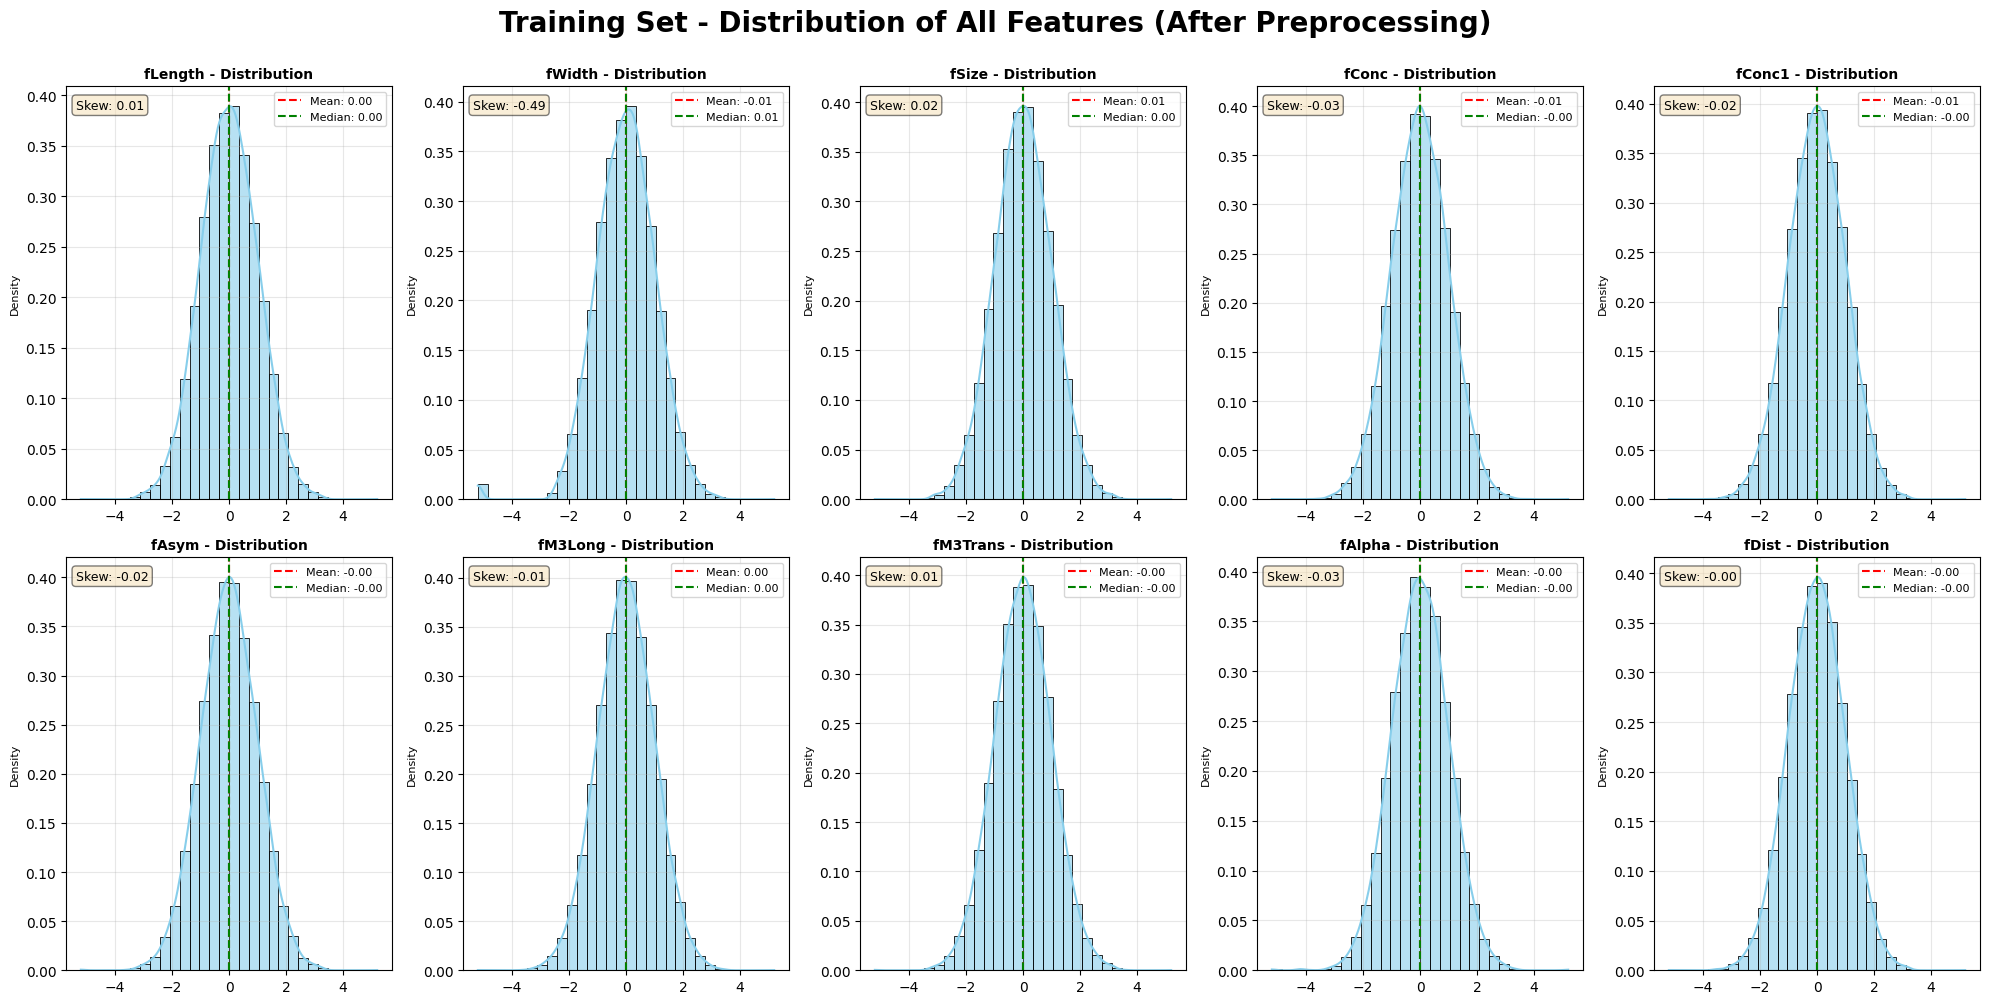

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']



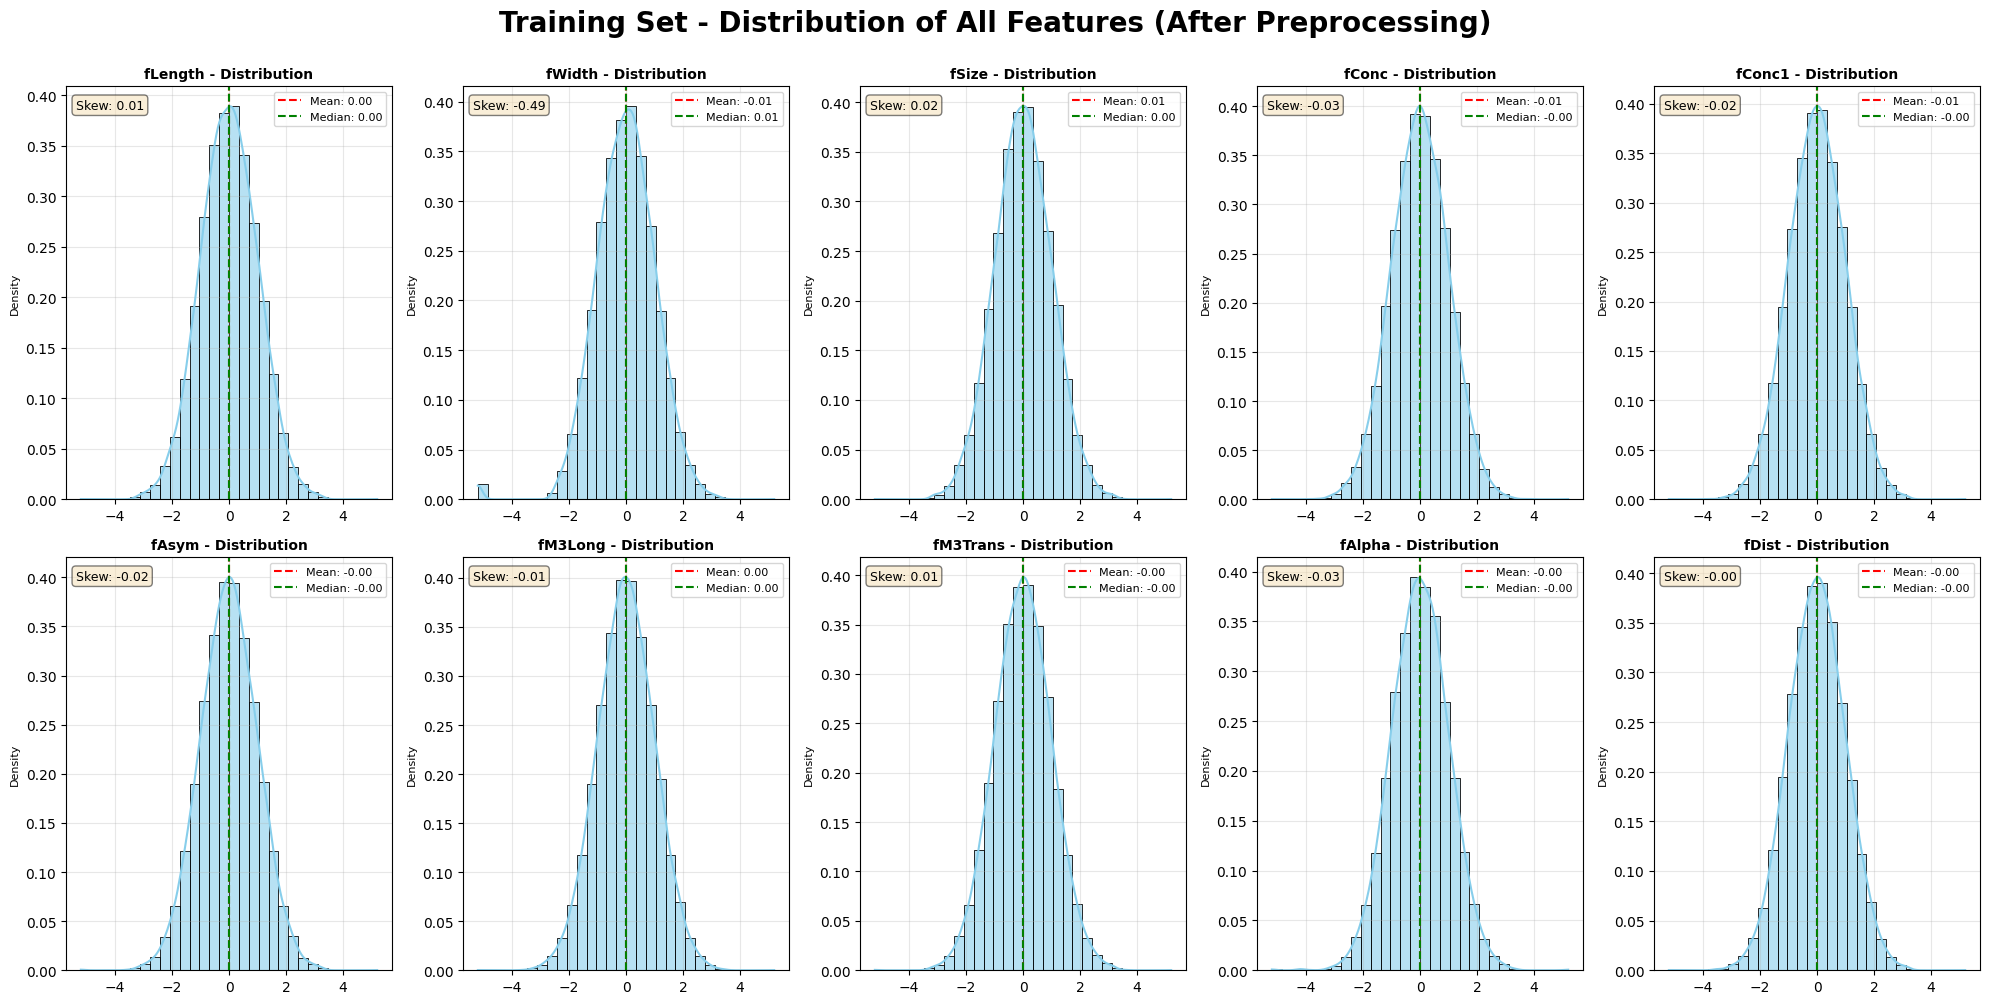

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


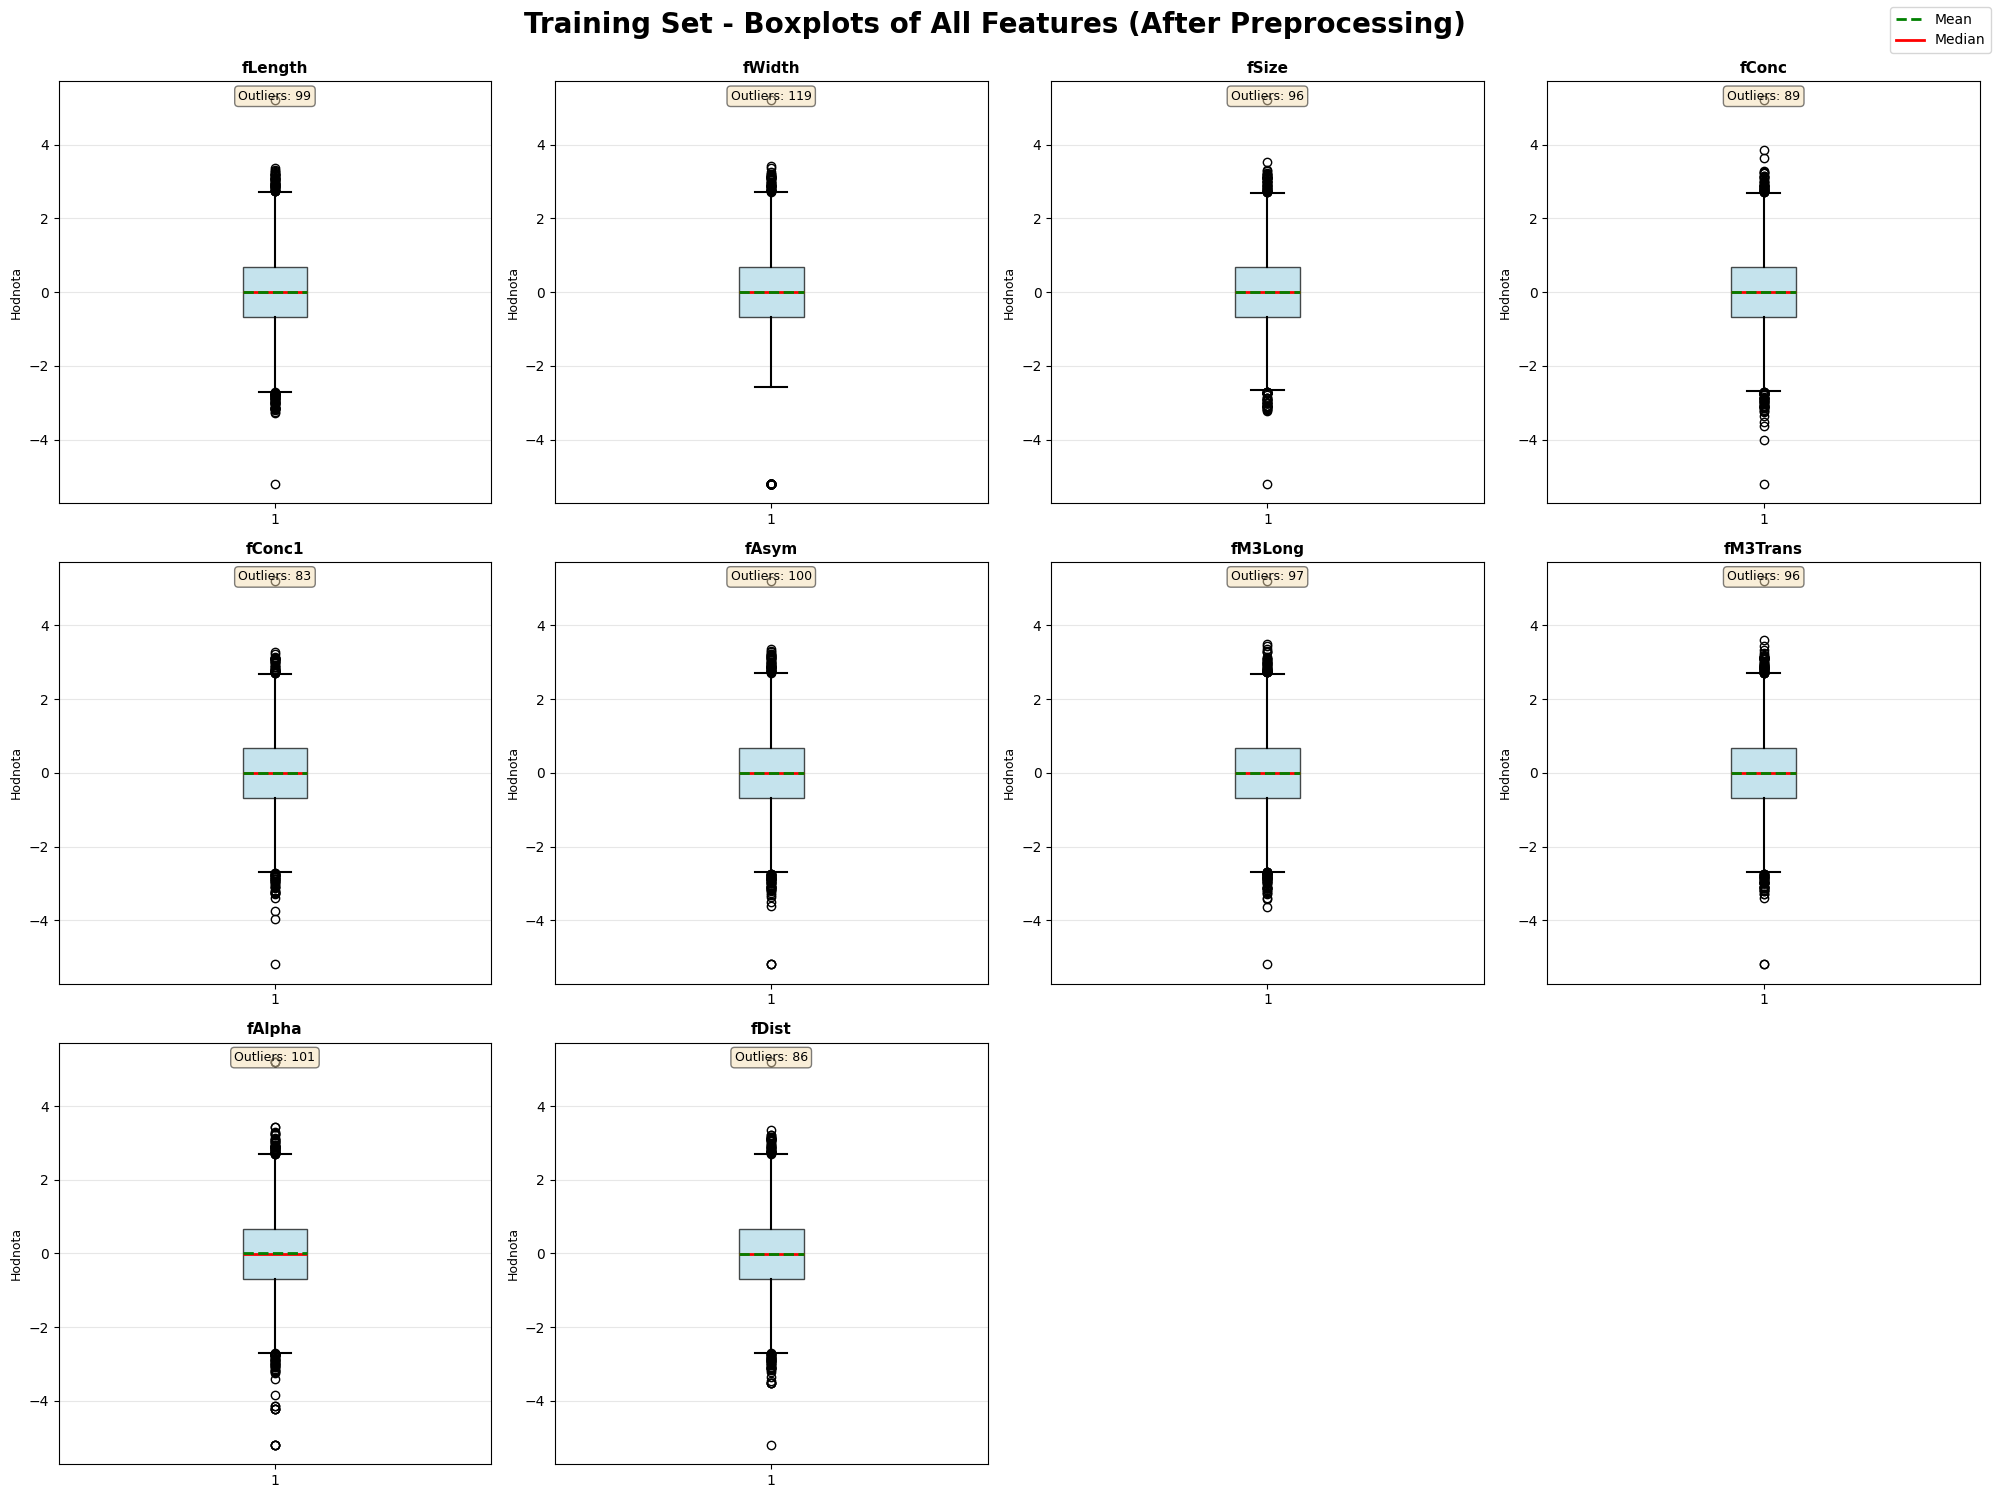


VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']



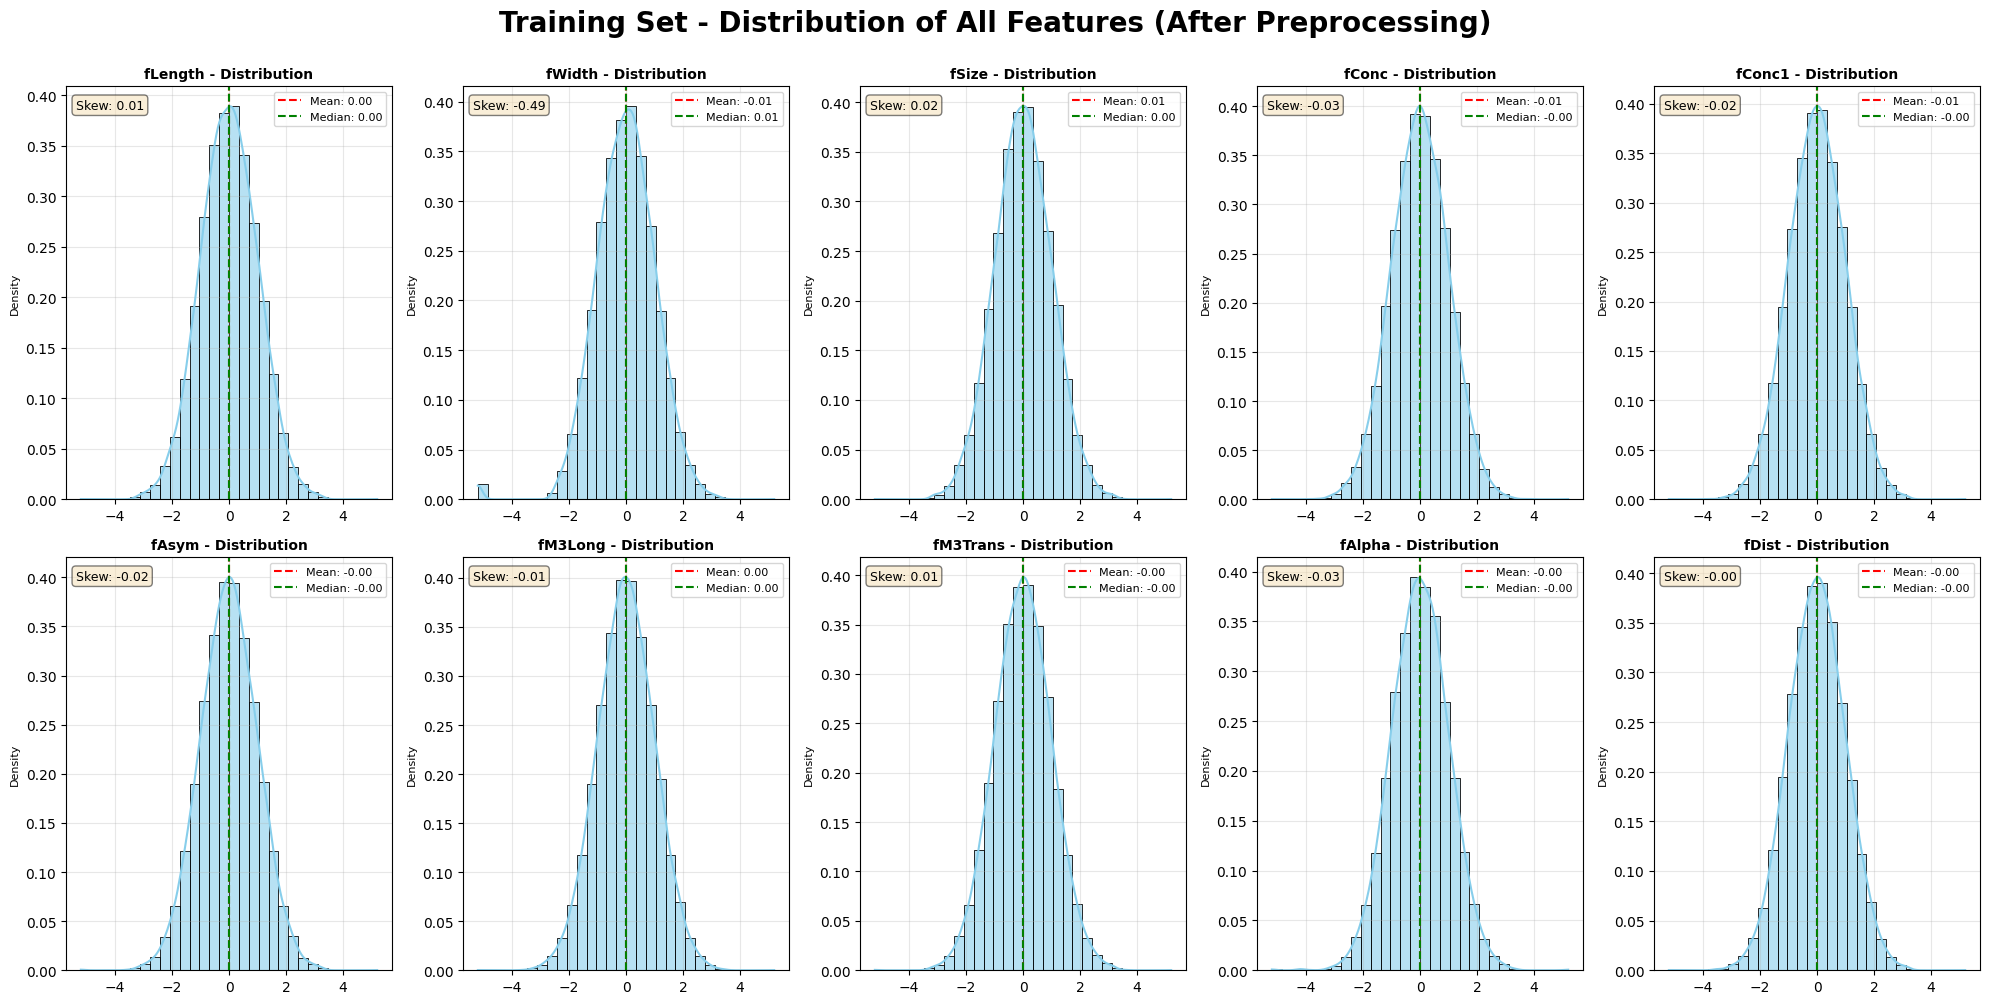

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


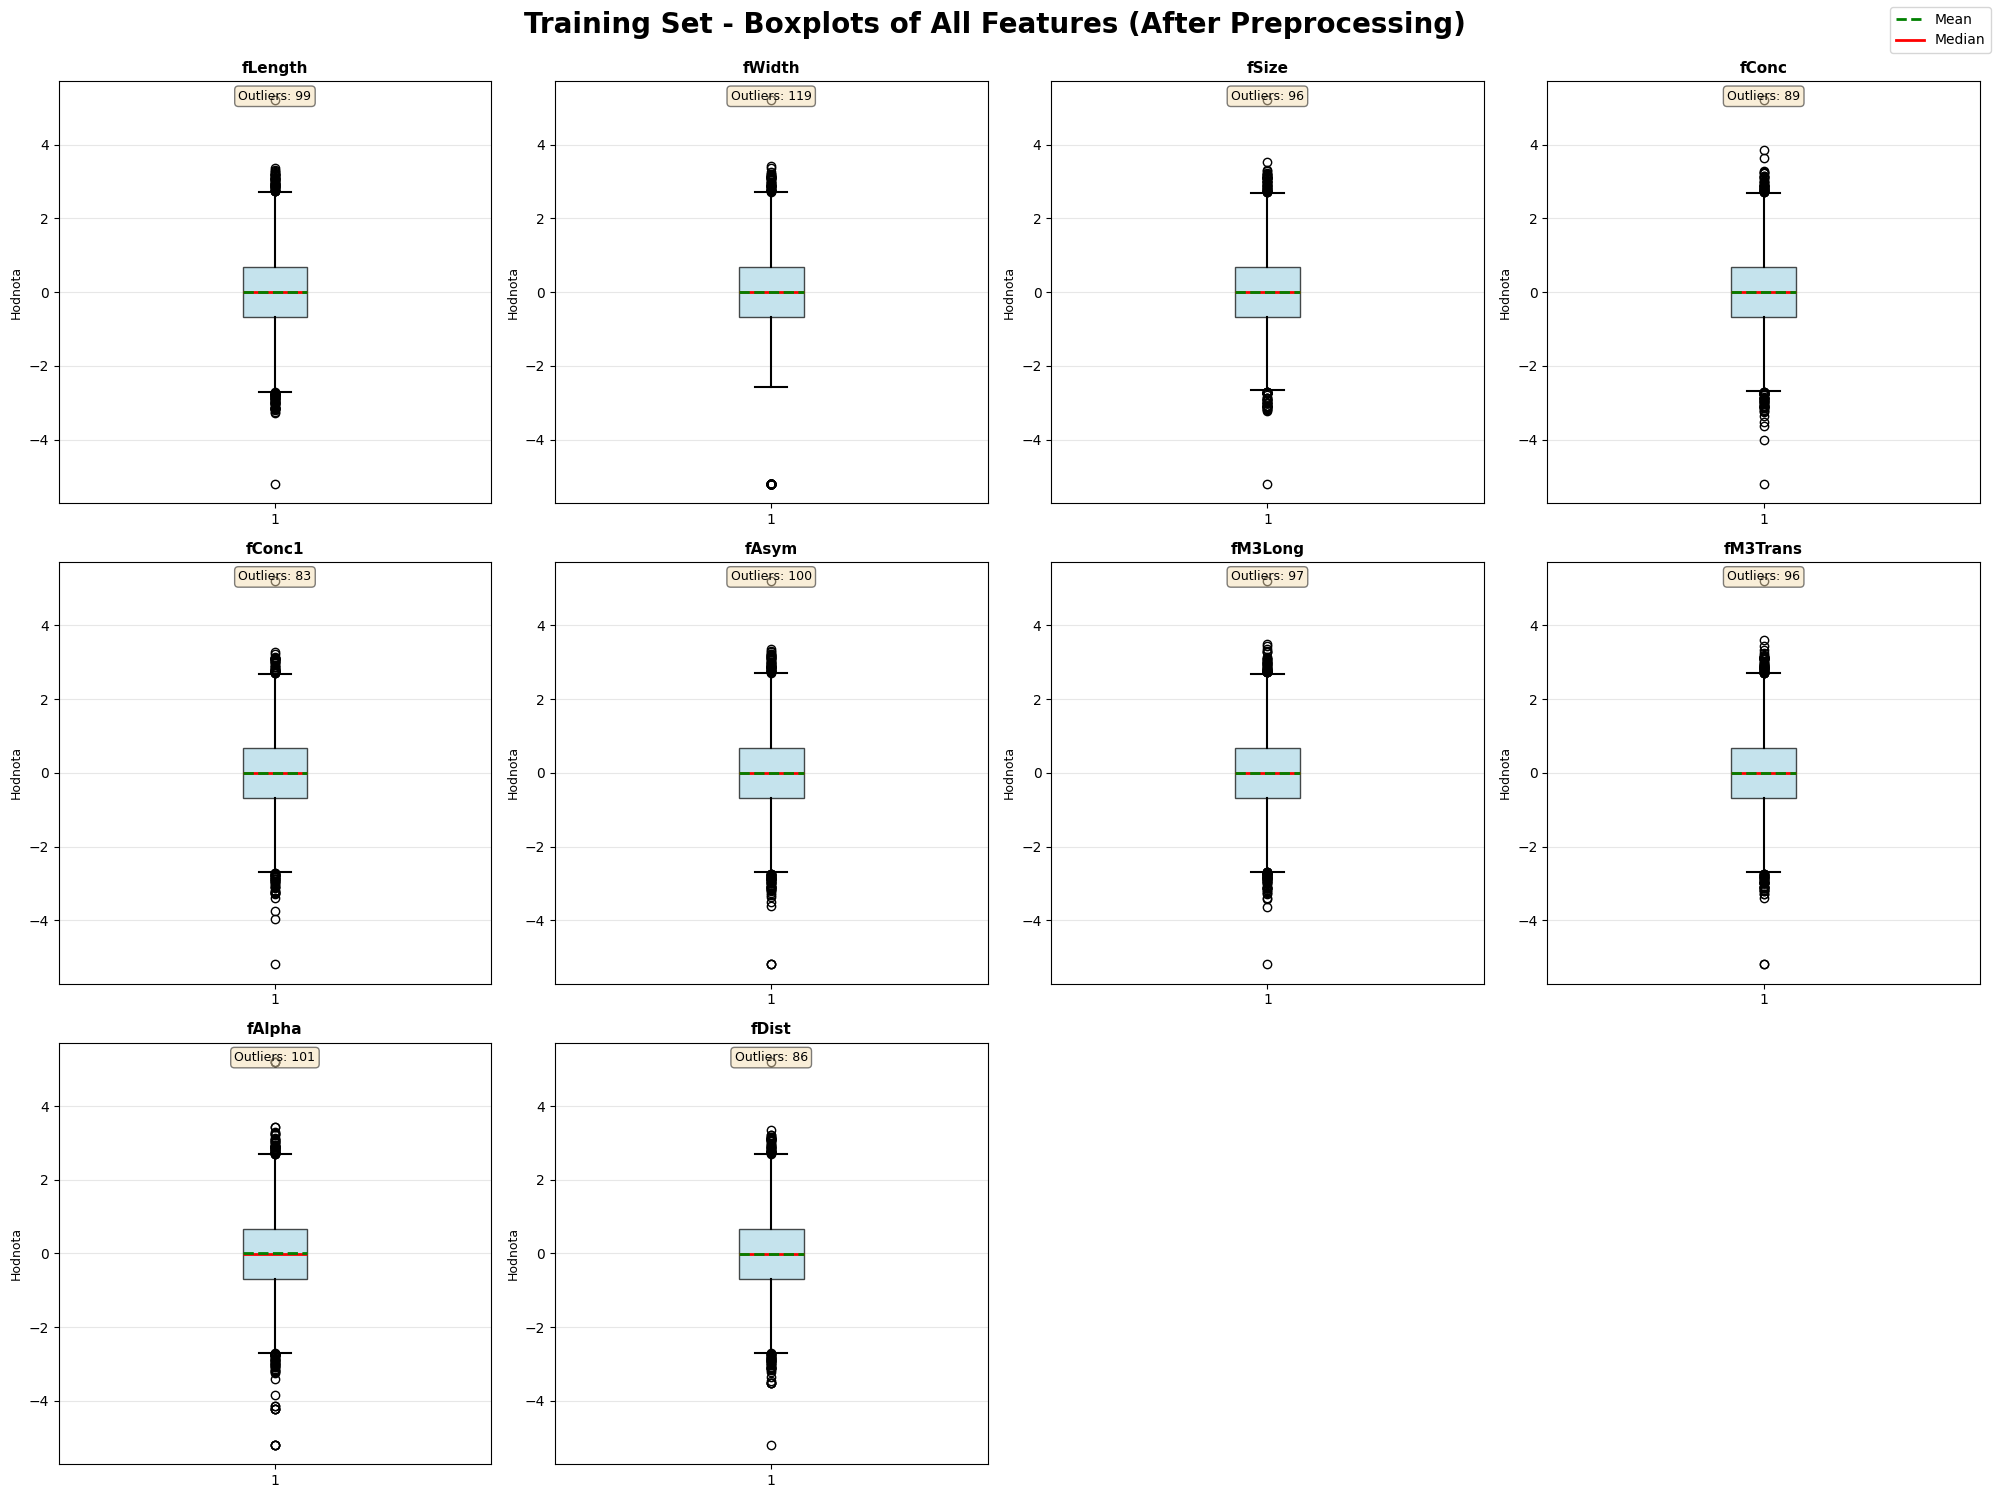


VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


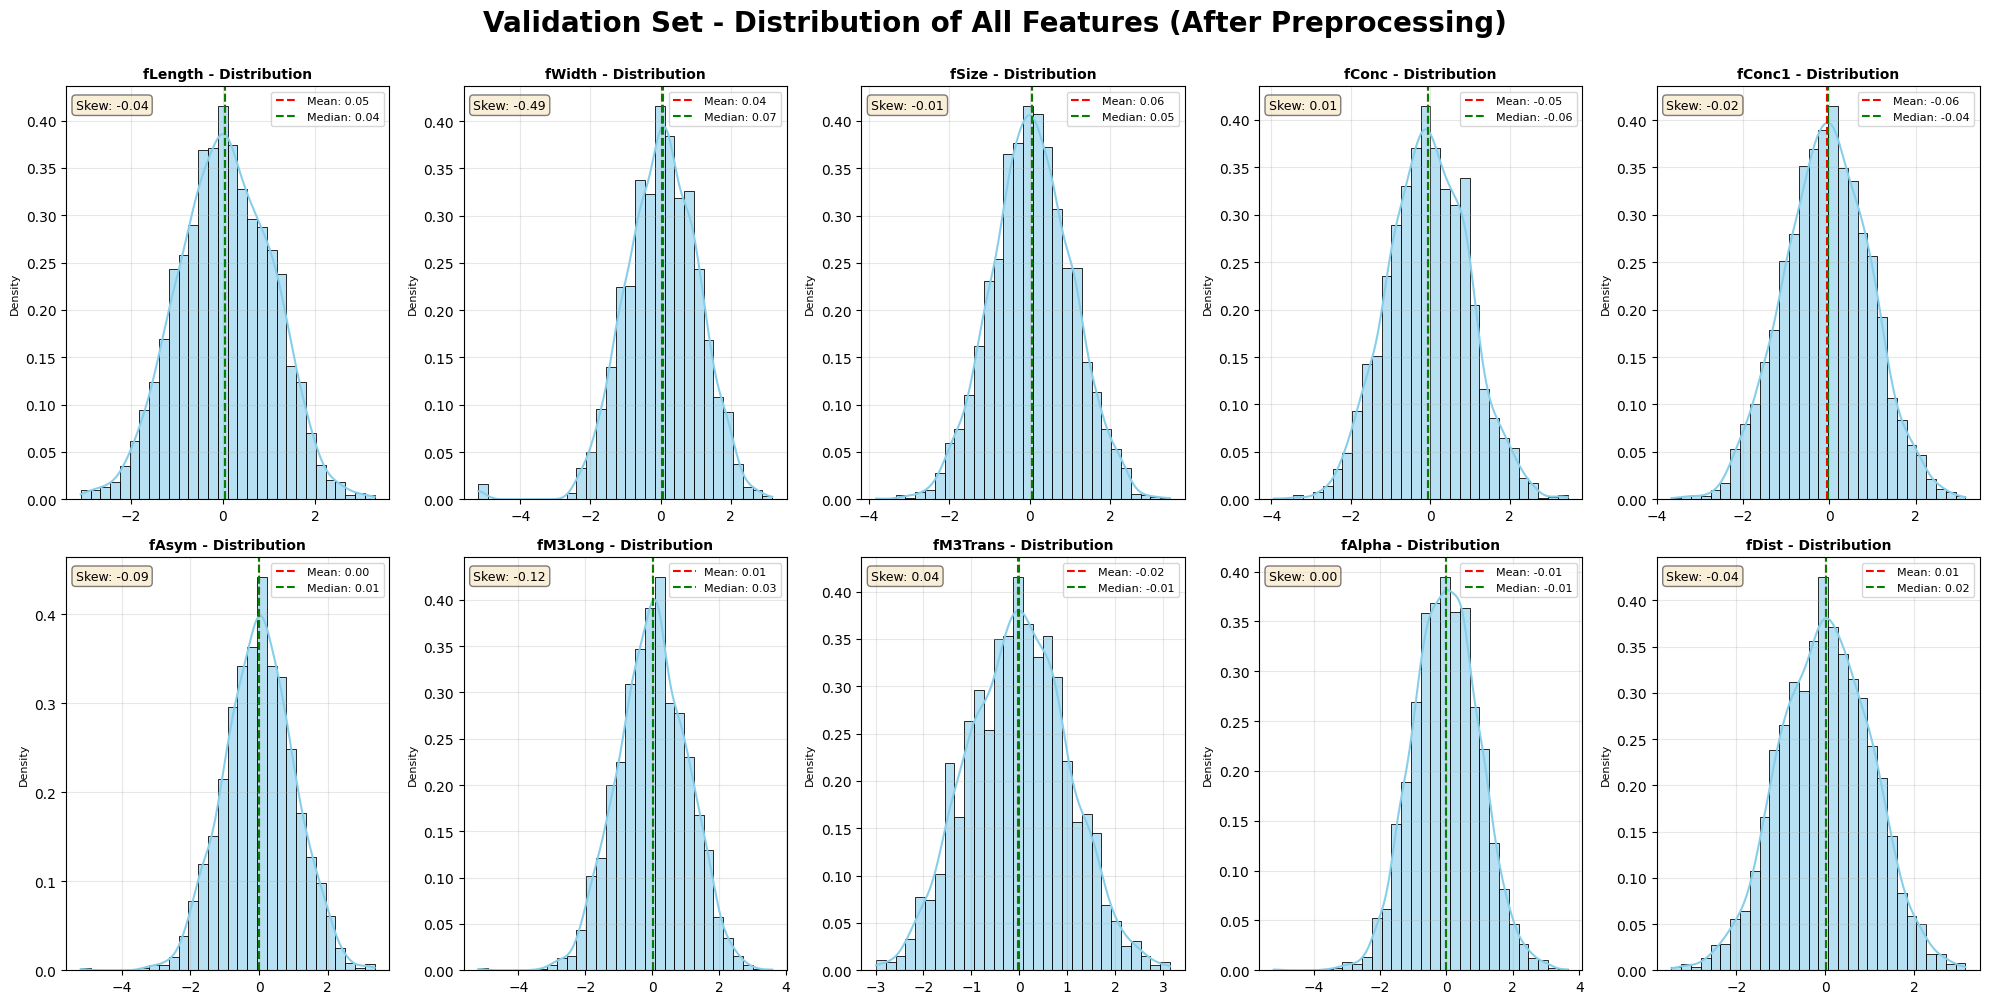

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']



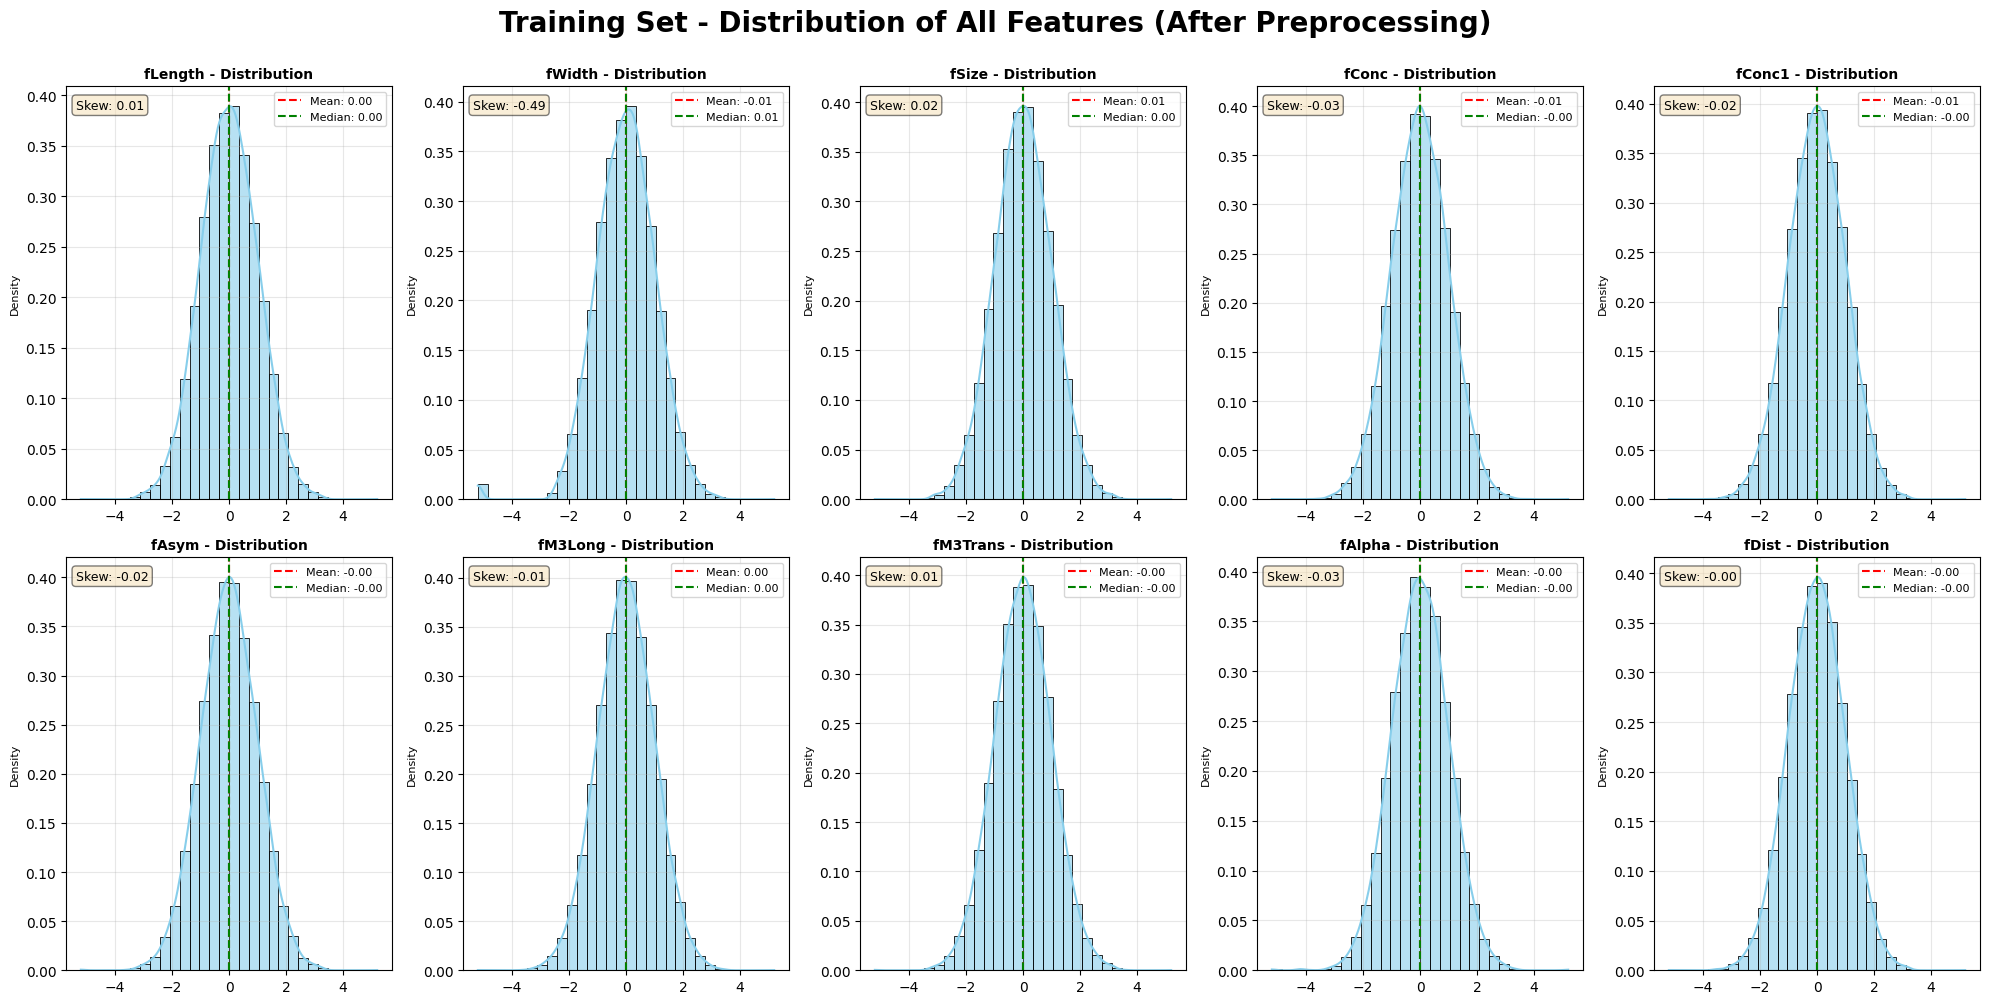

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


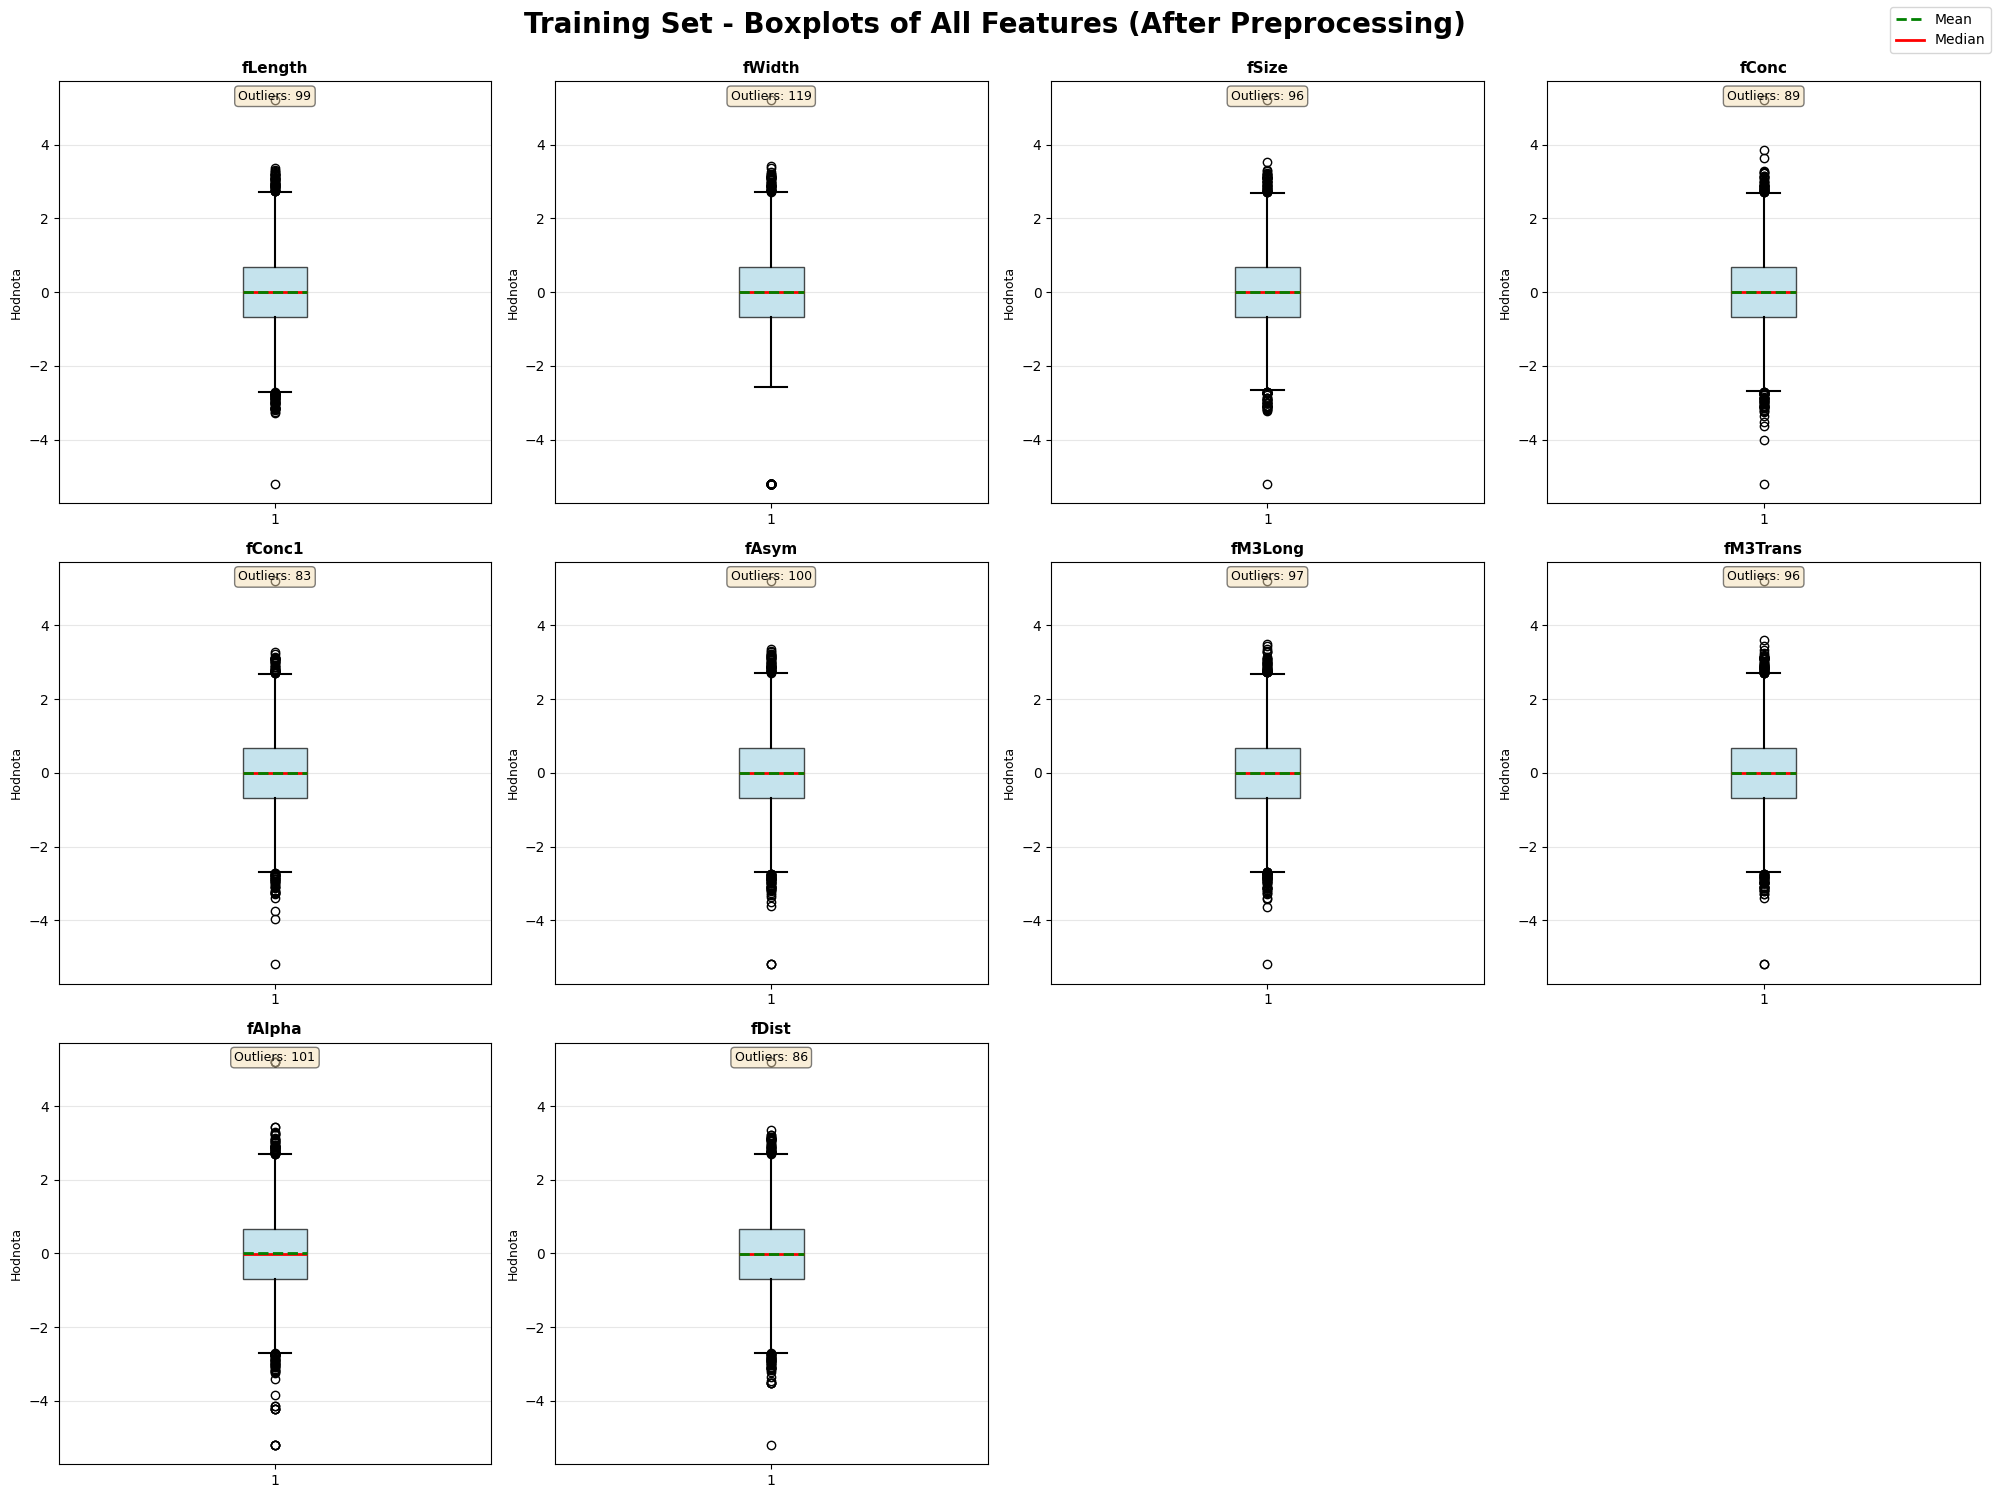


VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


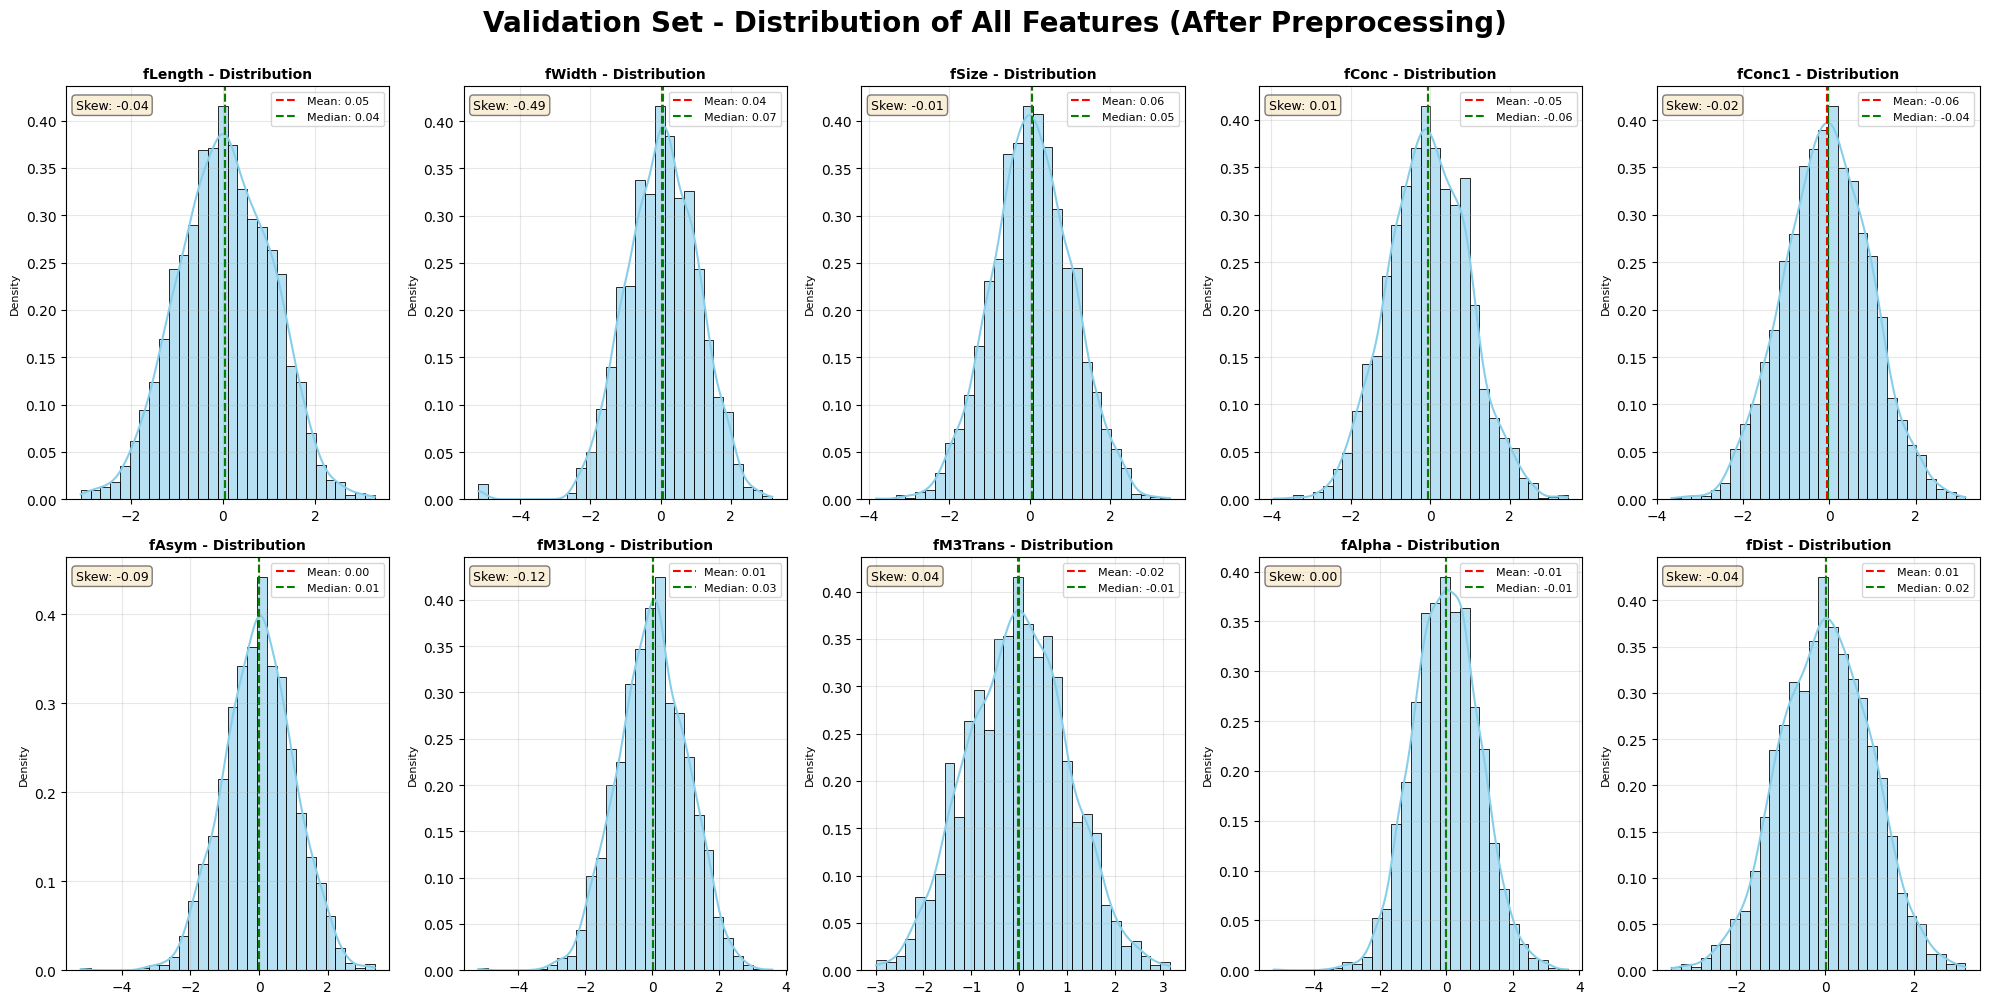

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


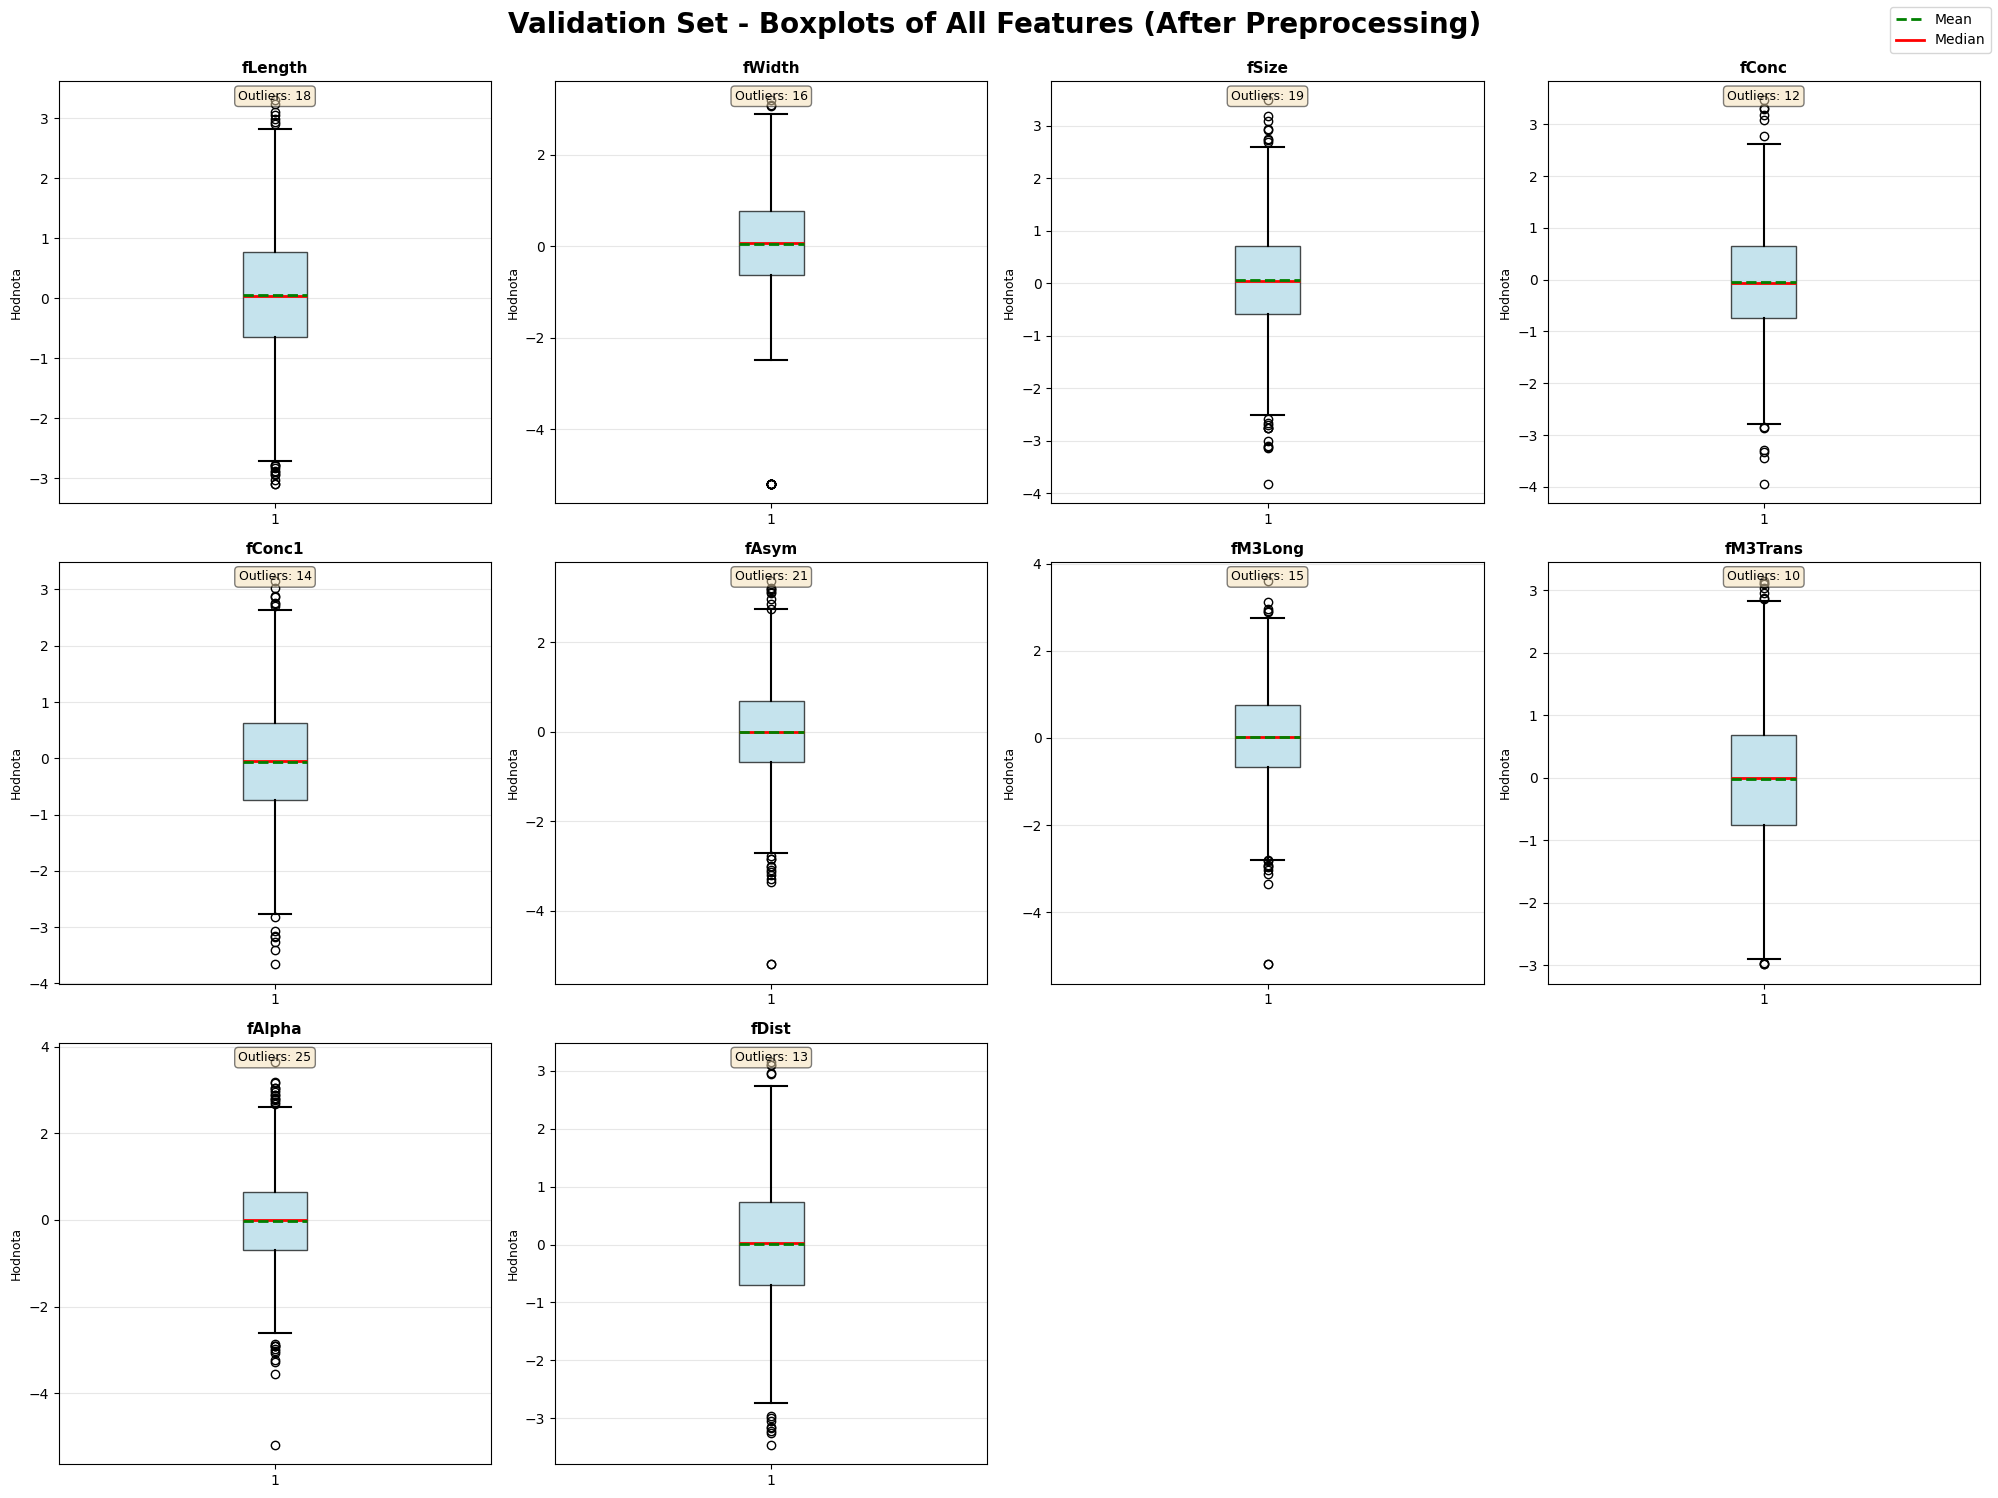


VISUALIZING TEST SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

VISUALIZING TEST SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']



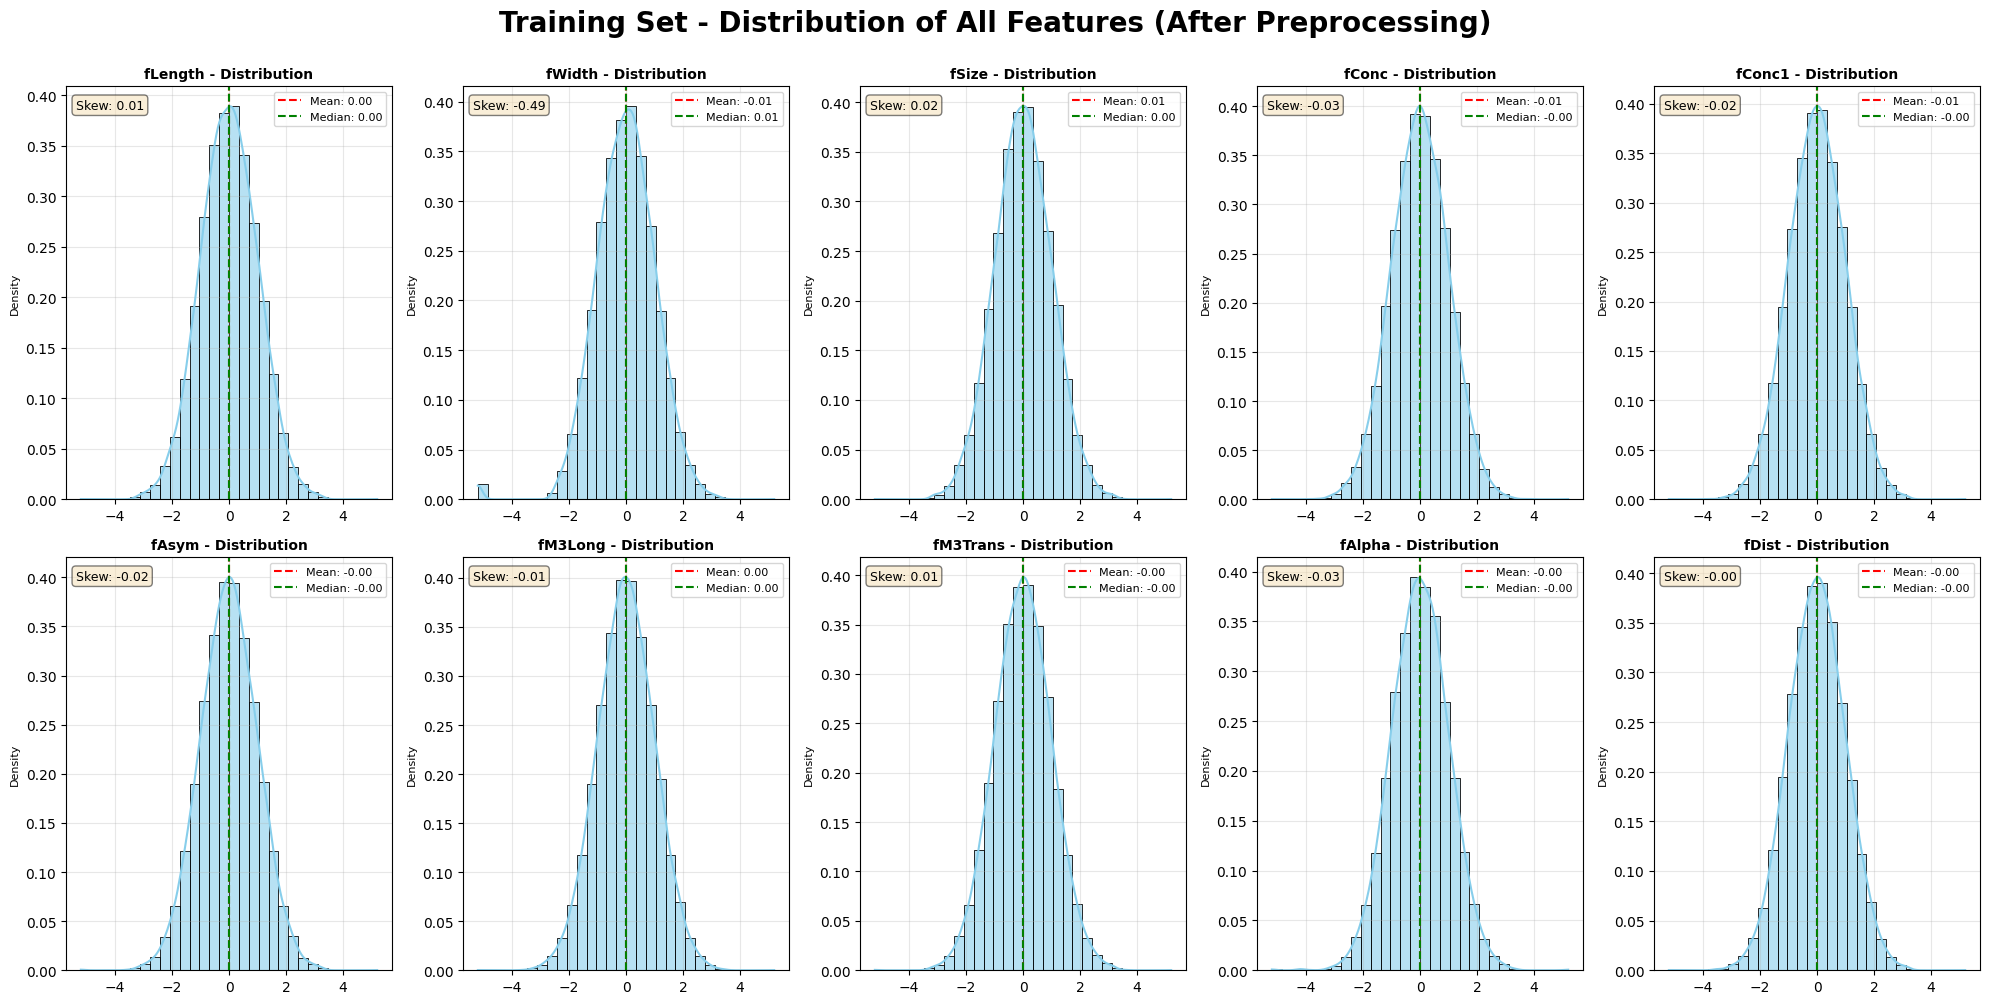

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


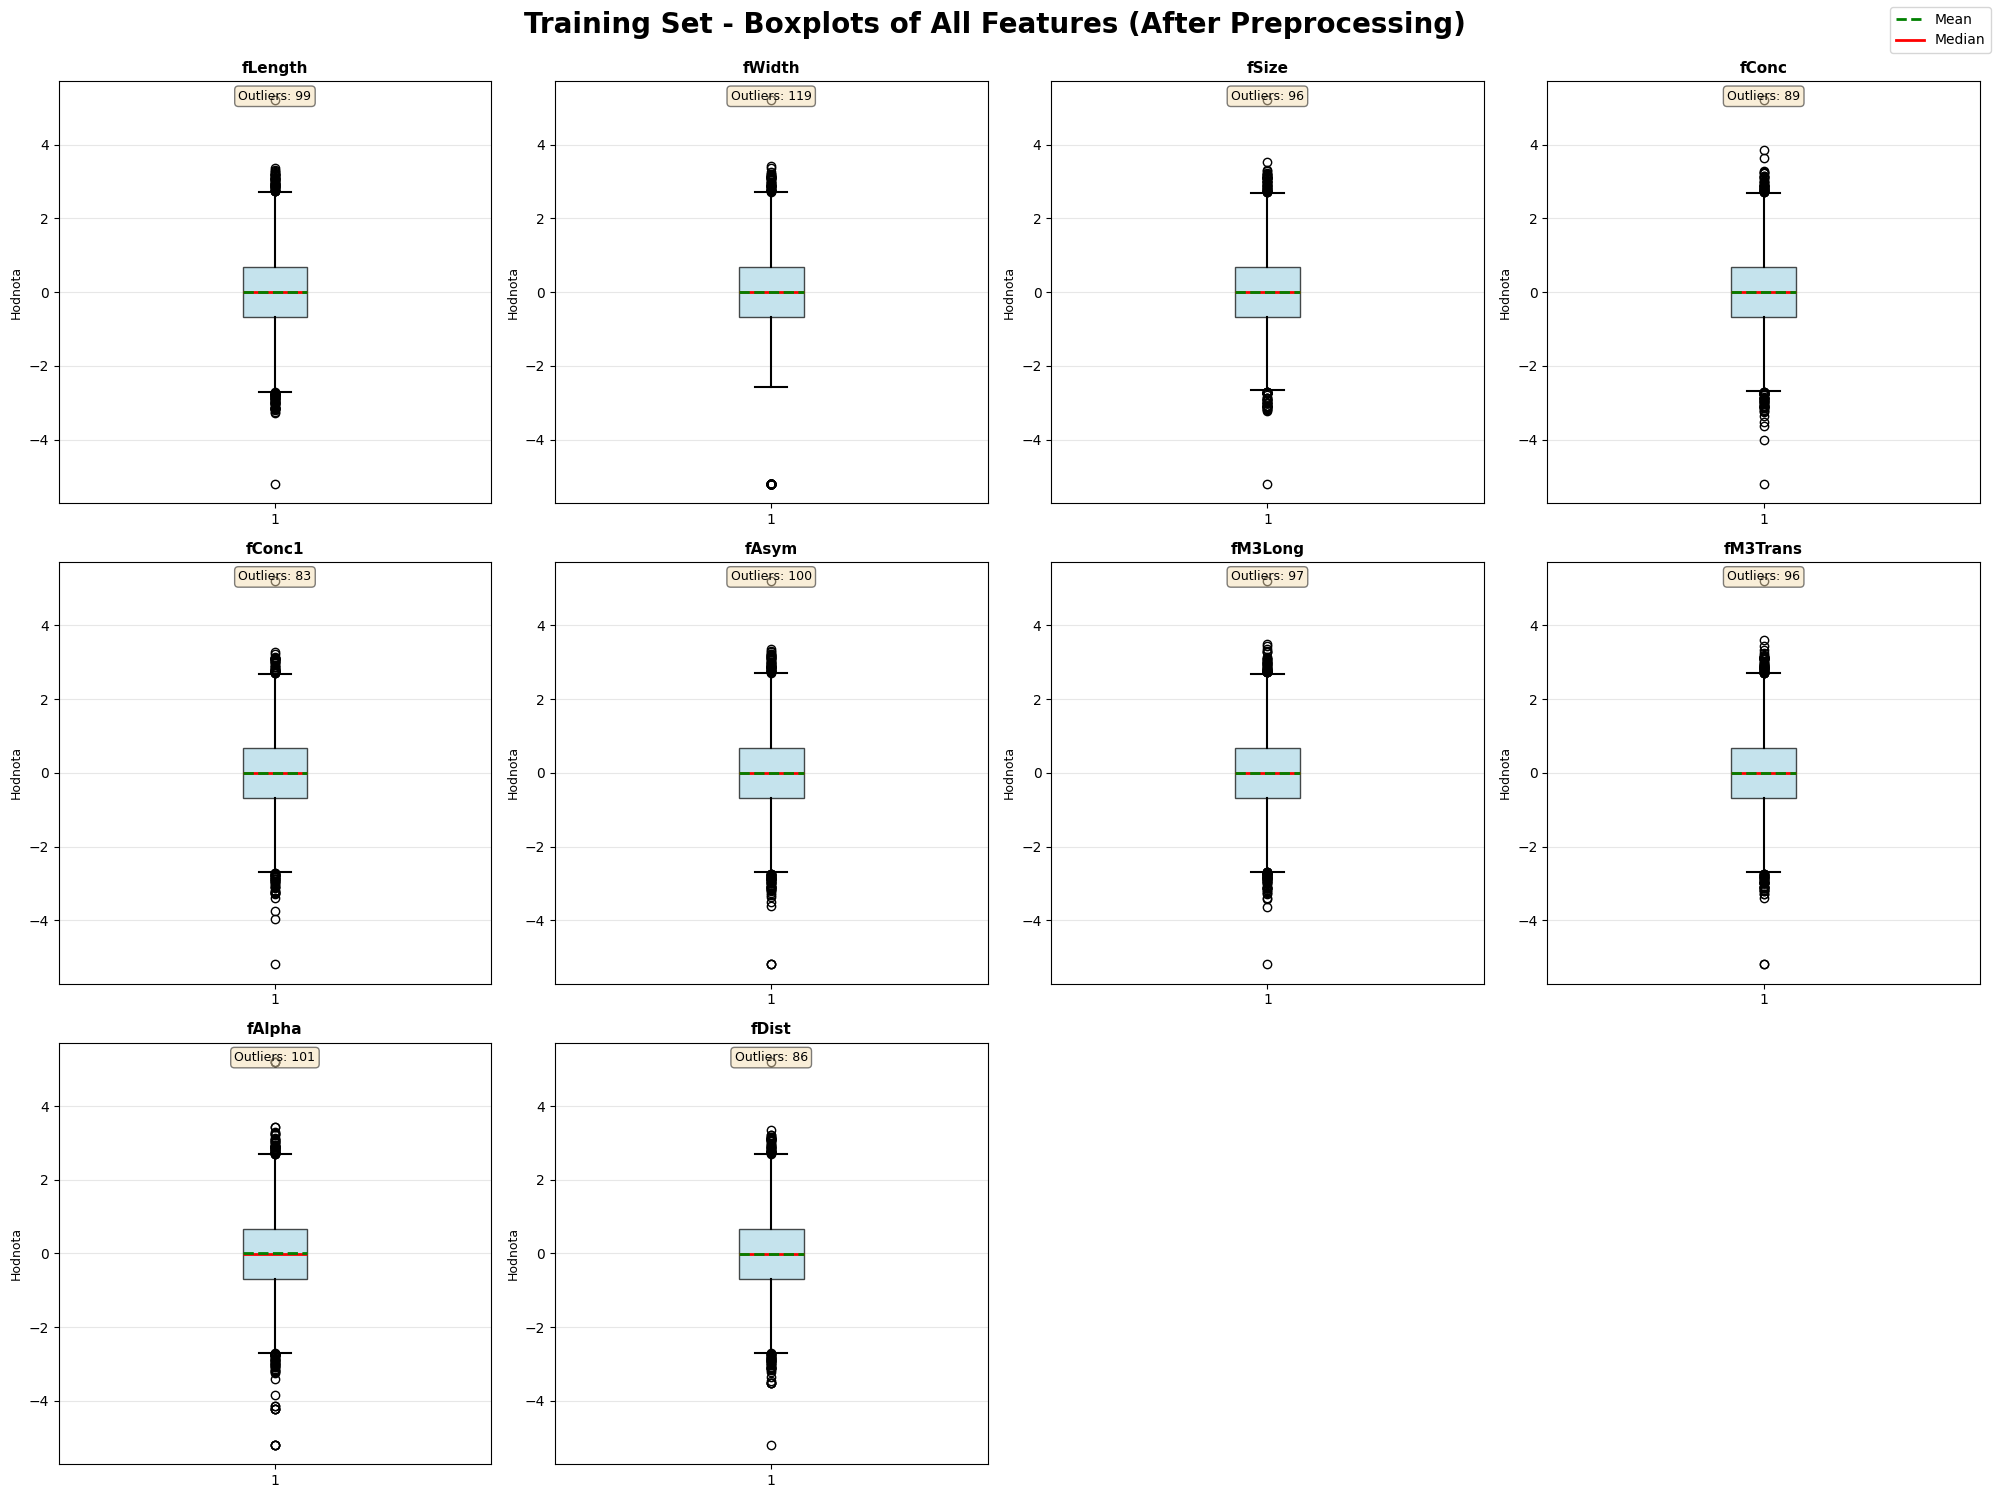


VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


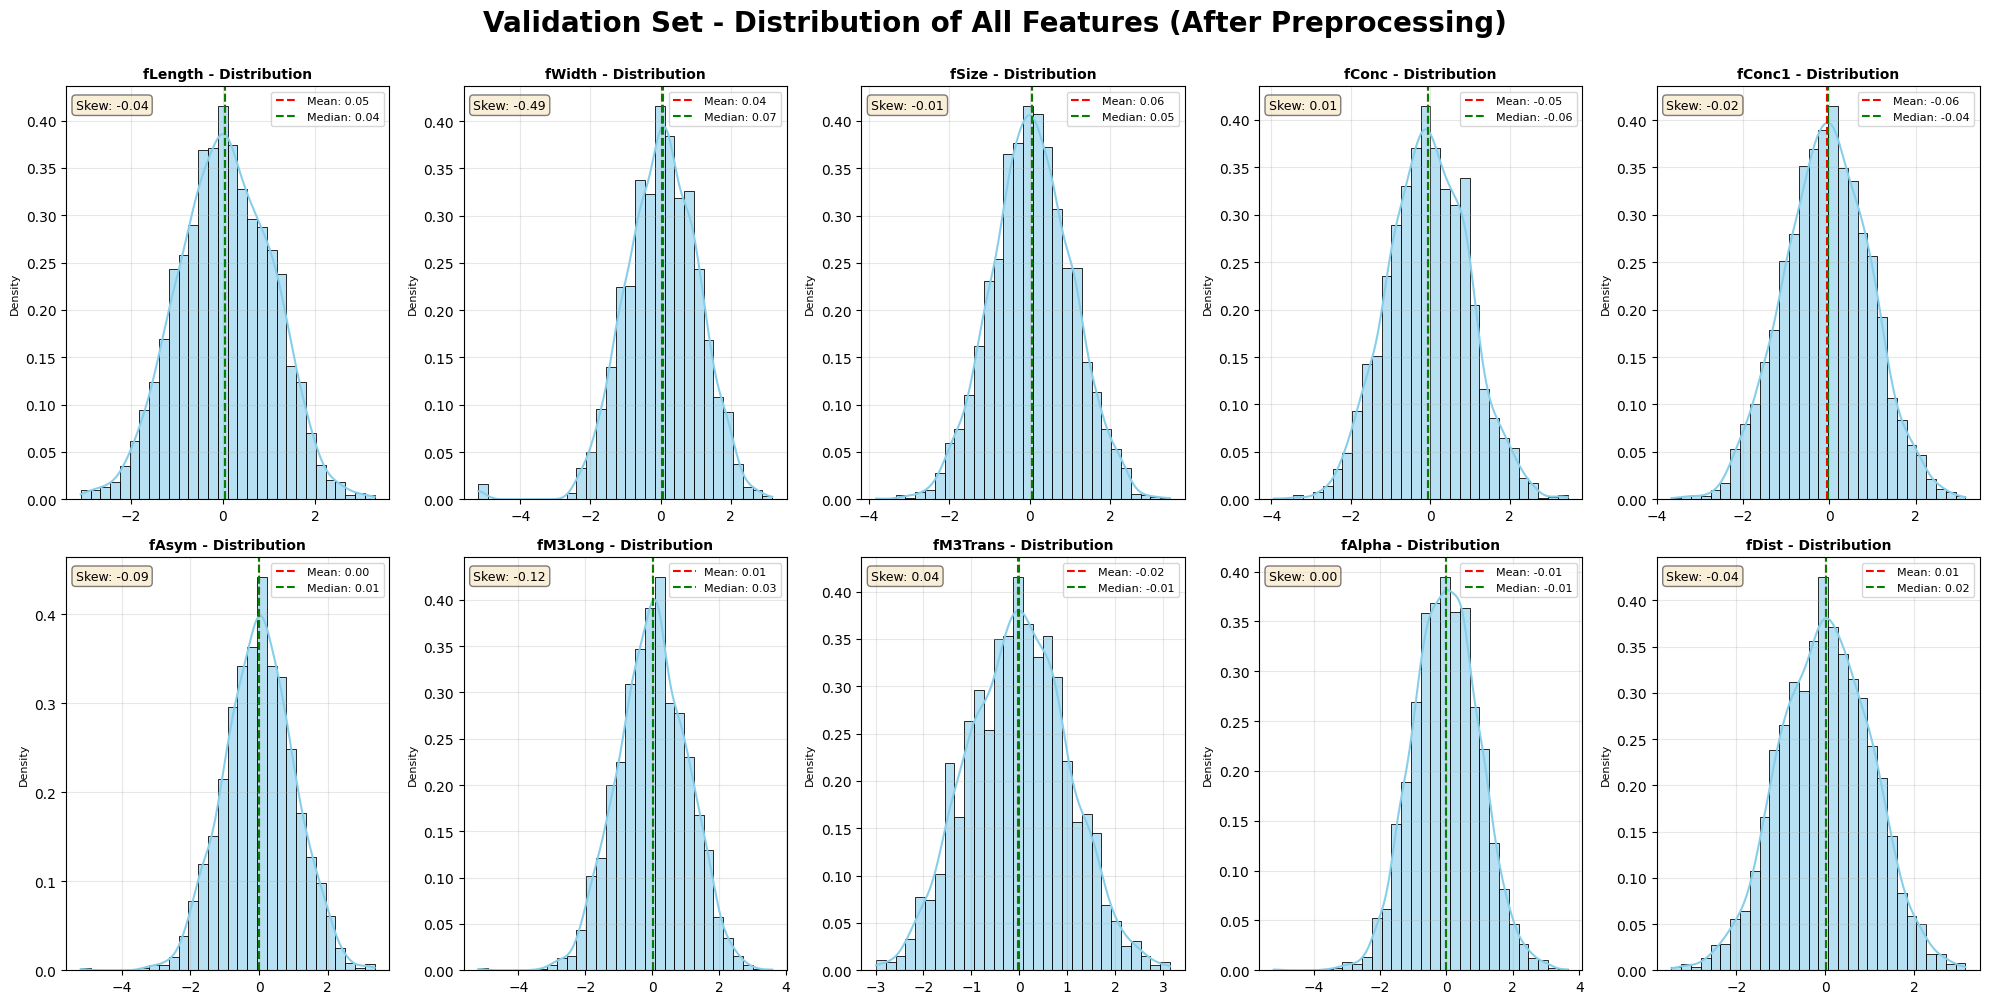

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


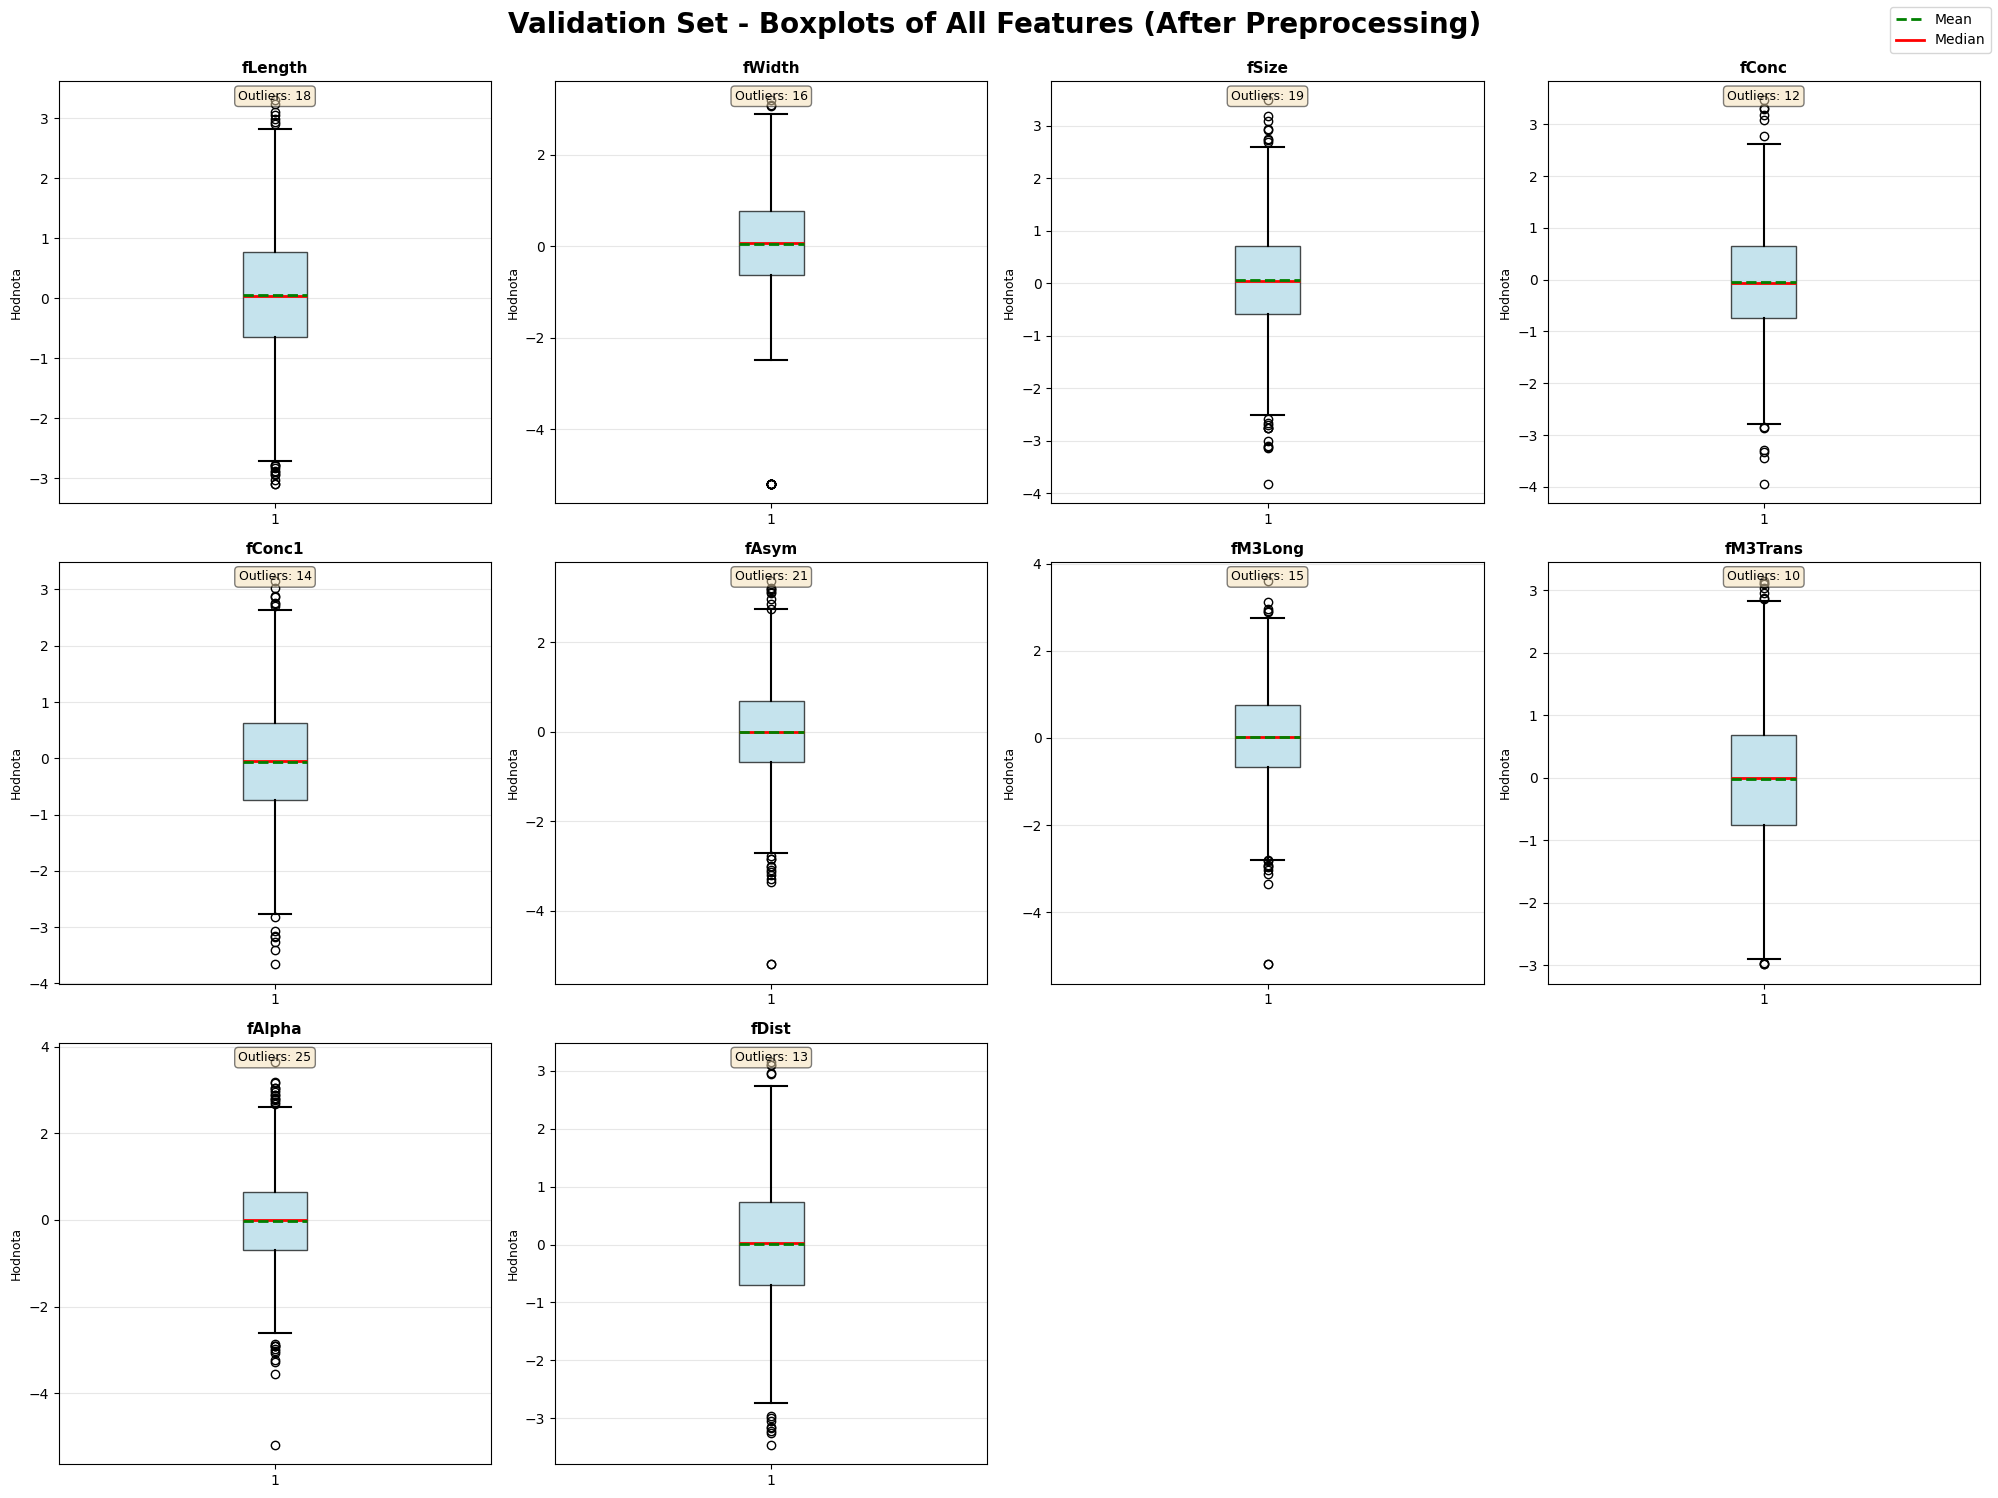


VISUALIZING TEST SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

VISUALIZING TEST SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


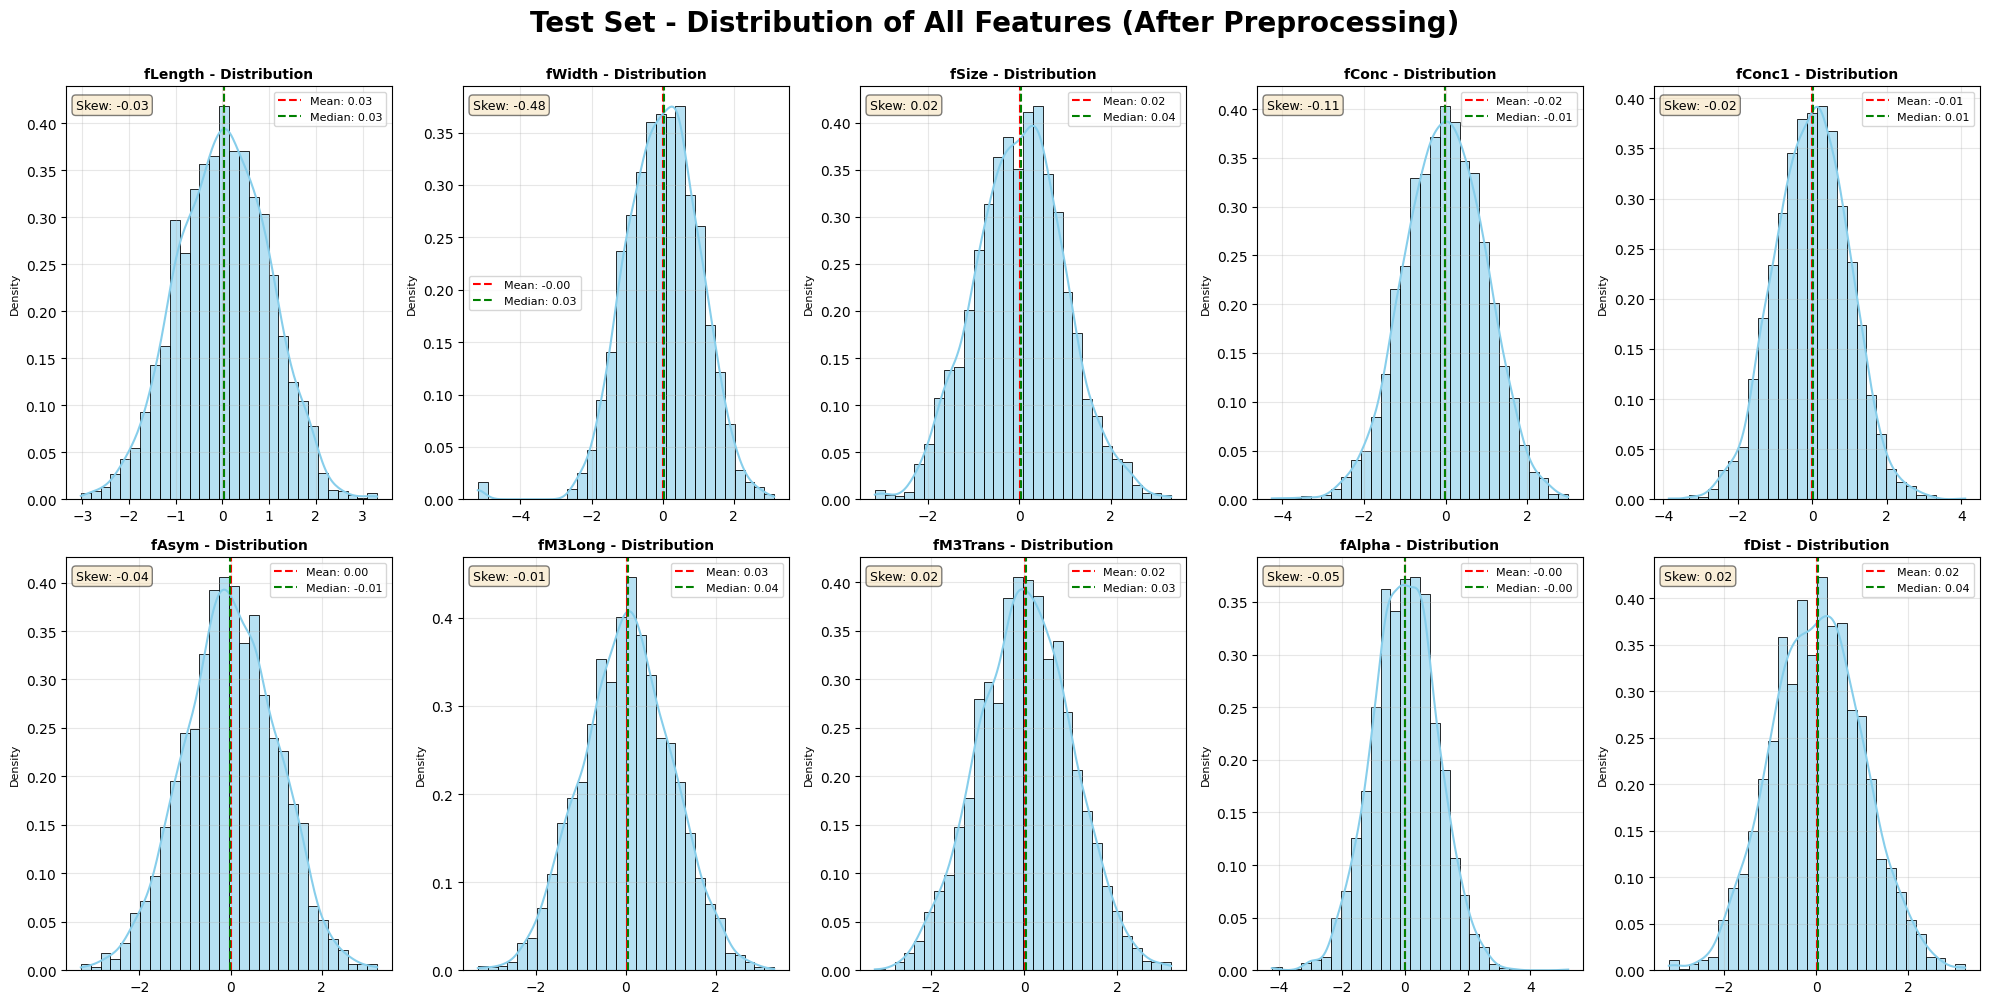

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']



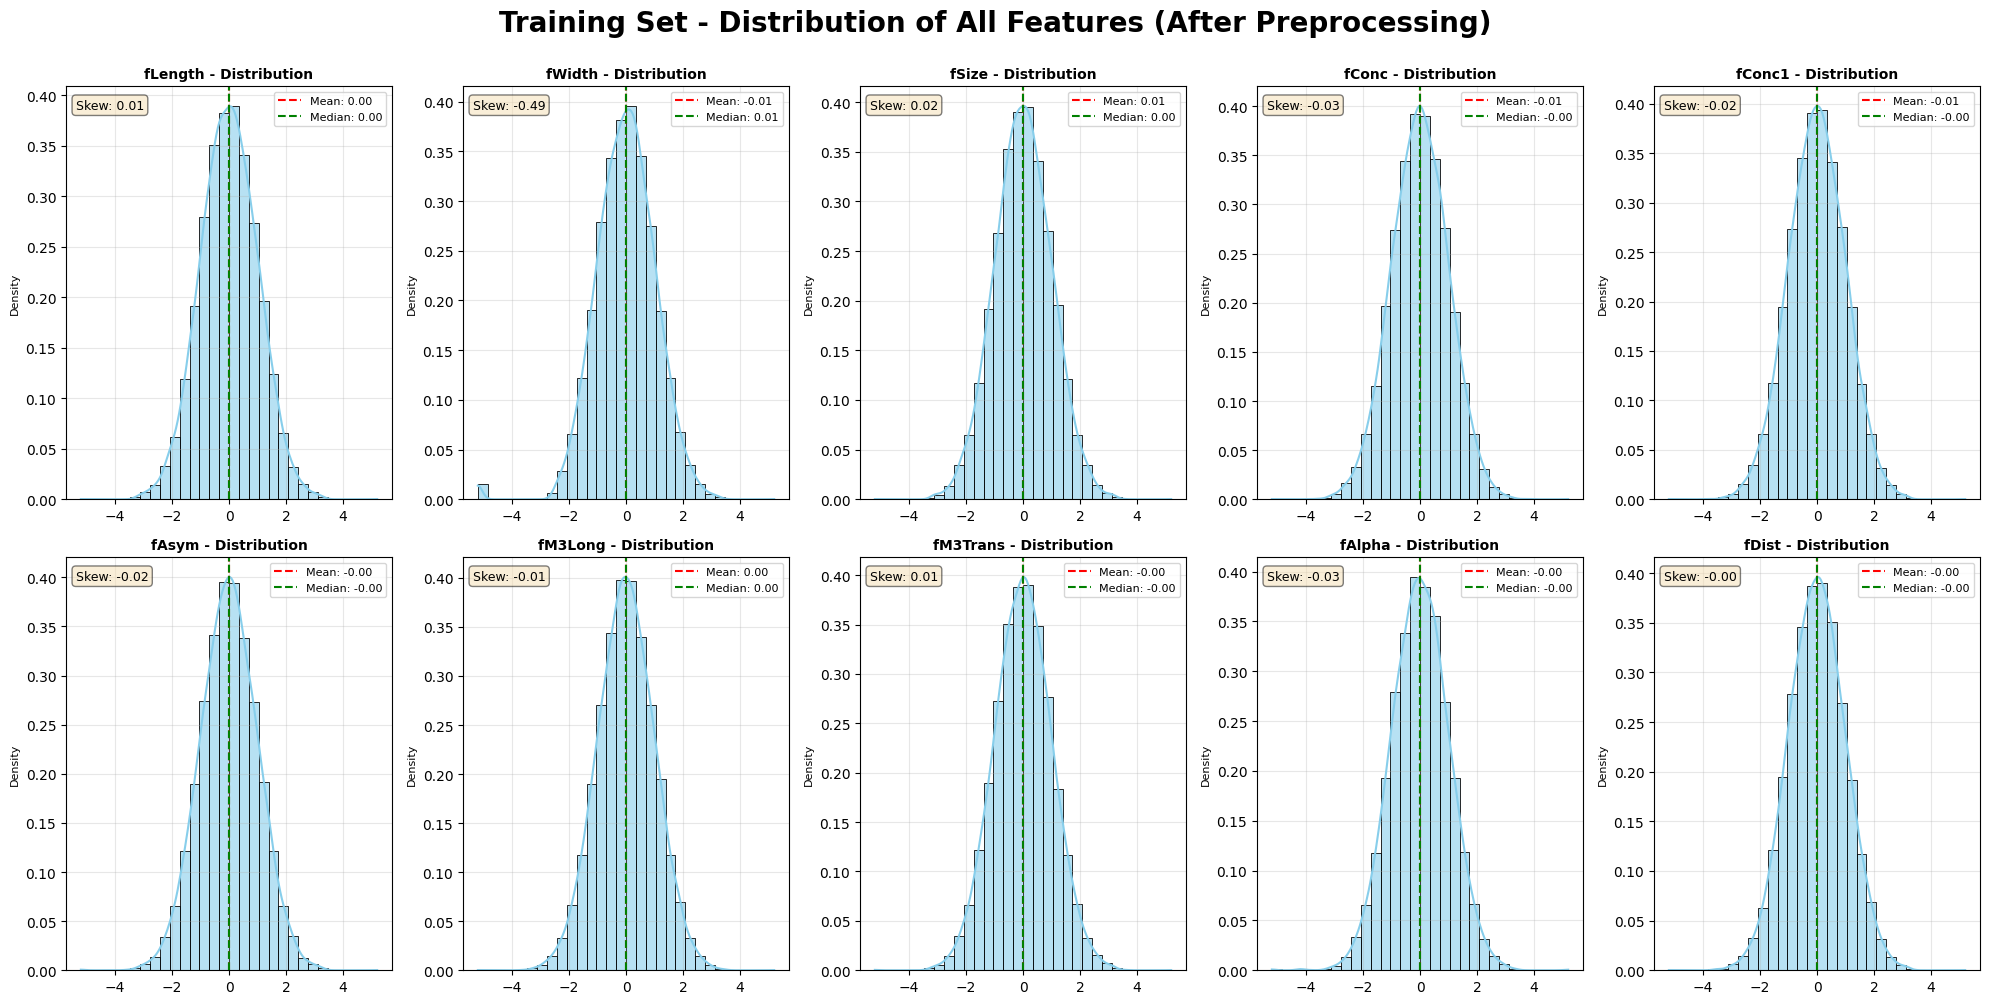

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


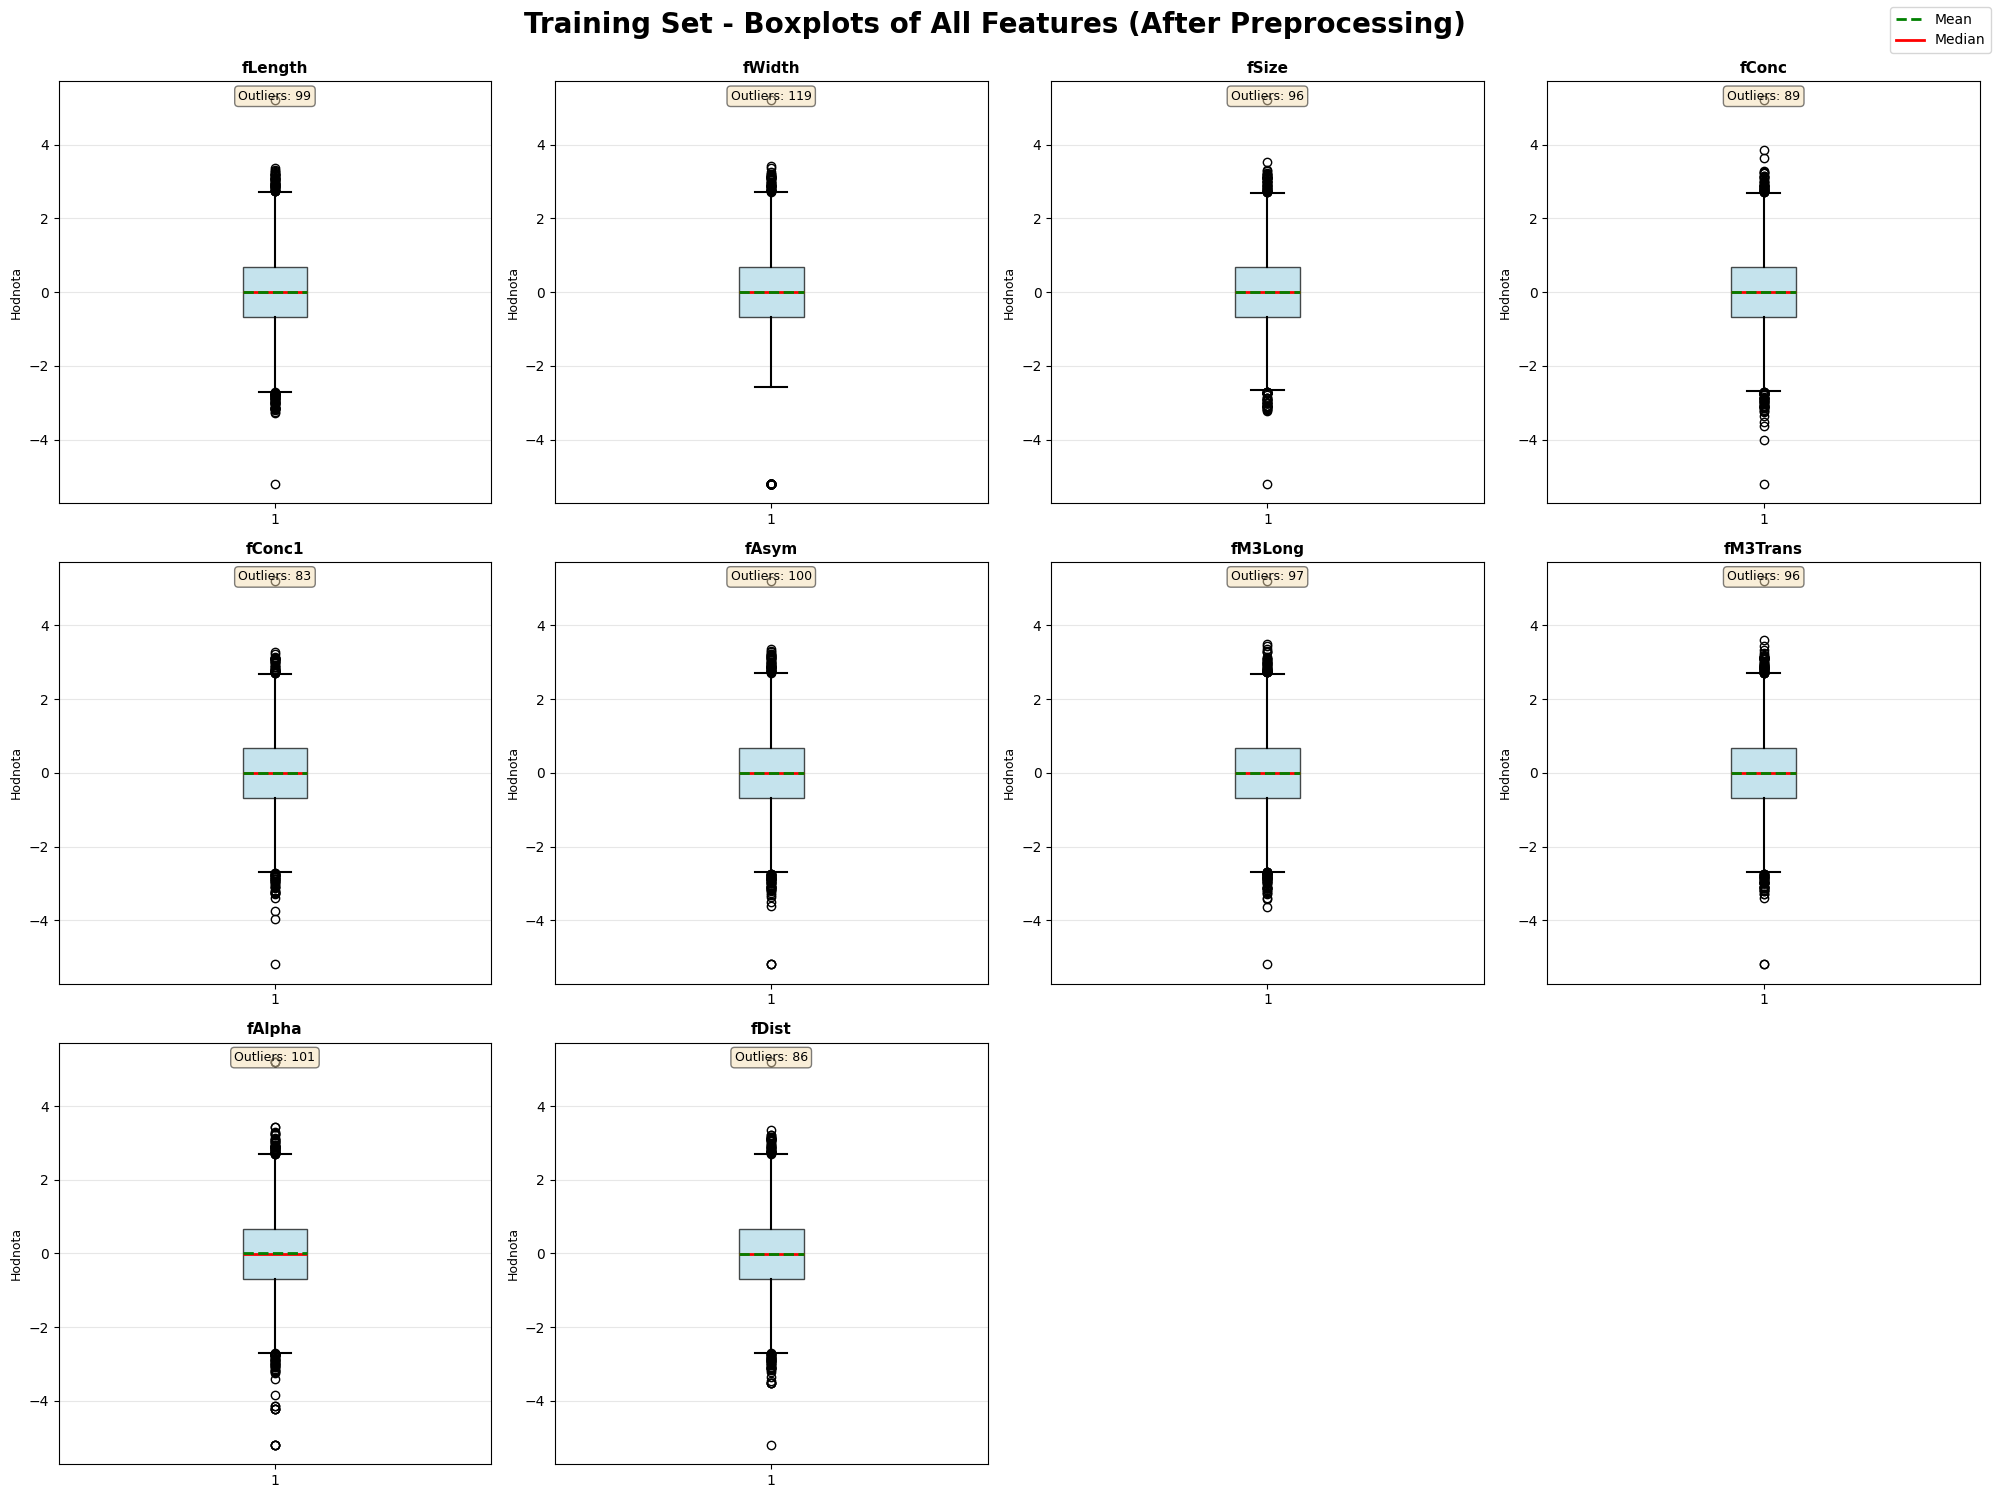


VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


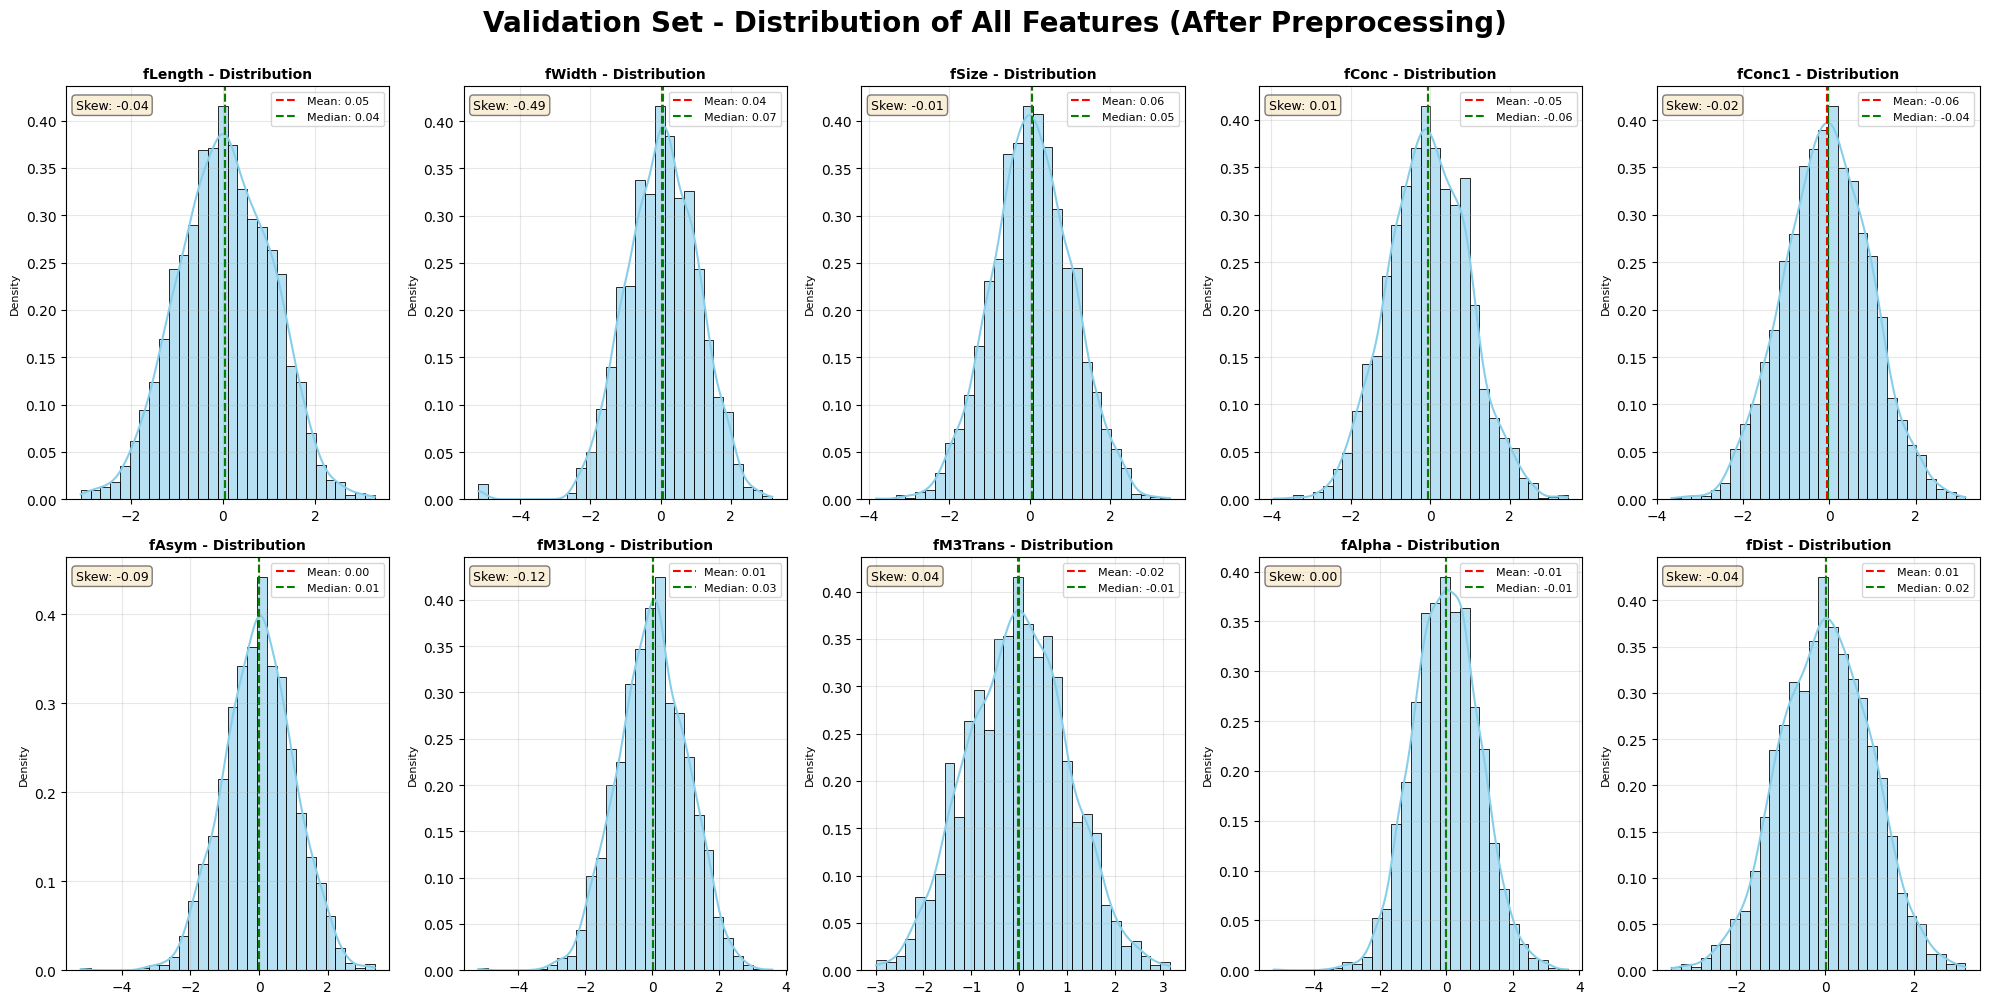

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


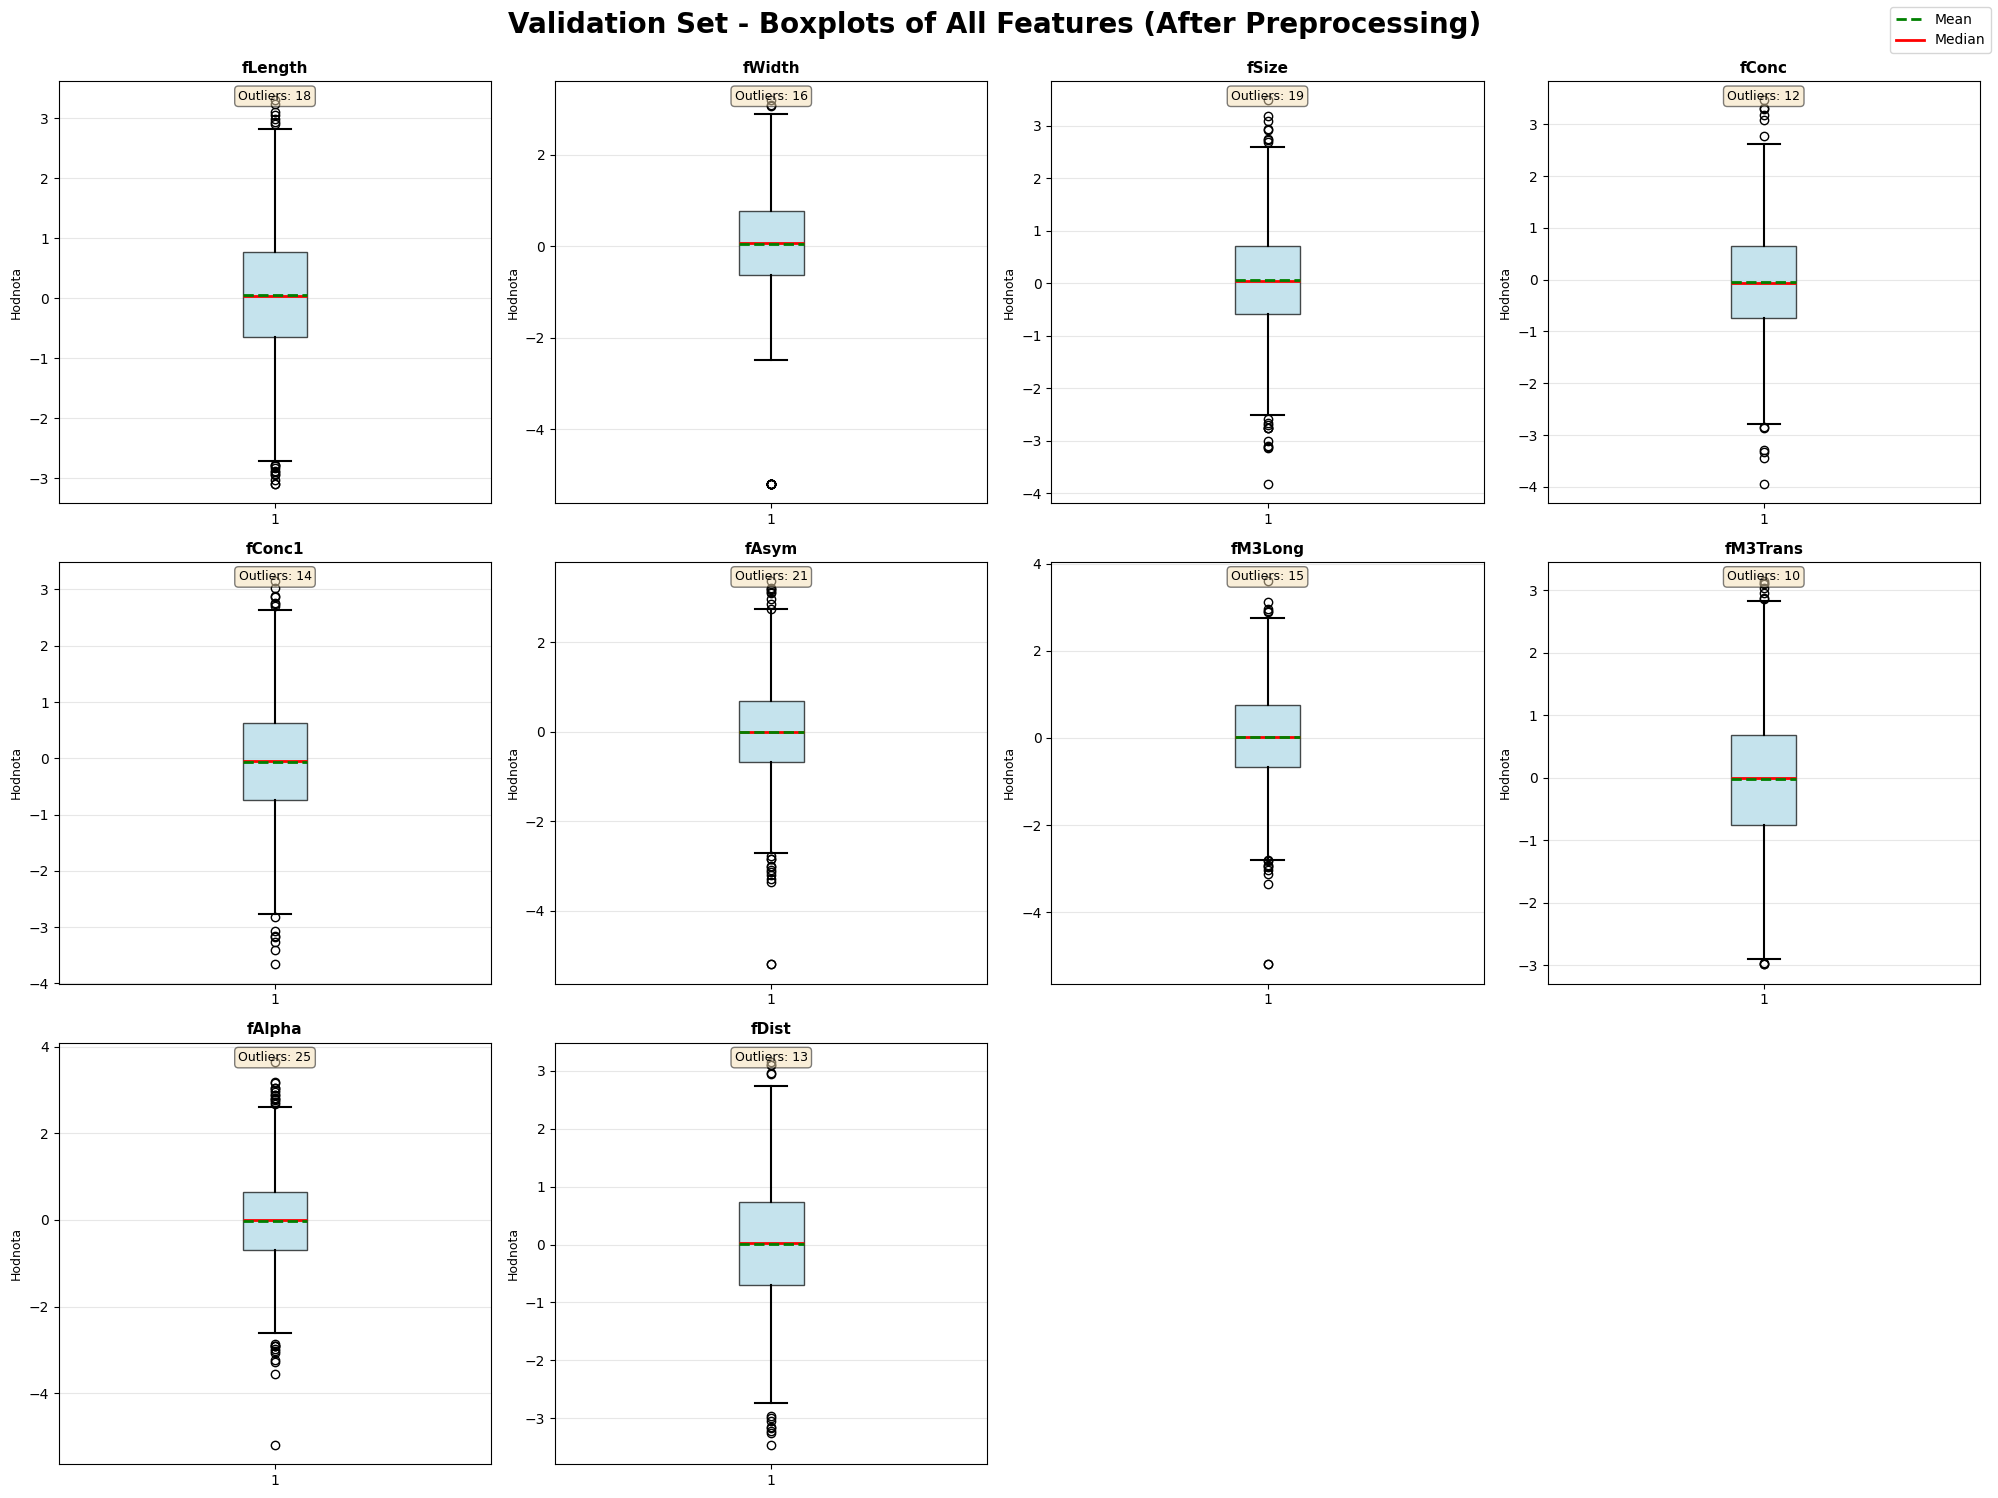


VISUALIZING TEST SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

VISUALIZING TEST SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


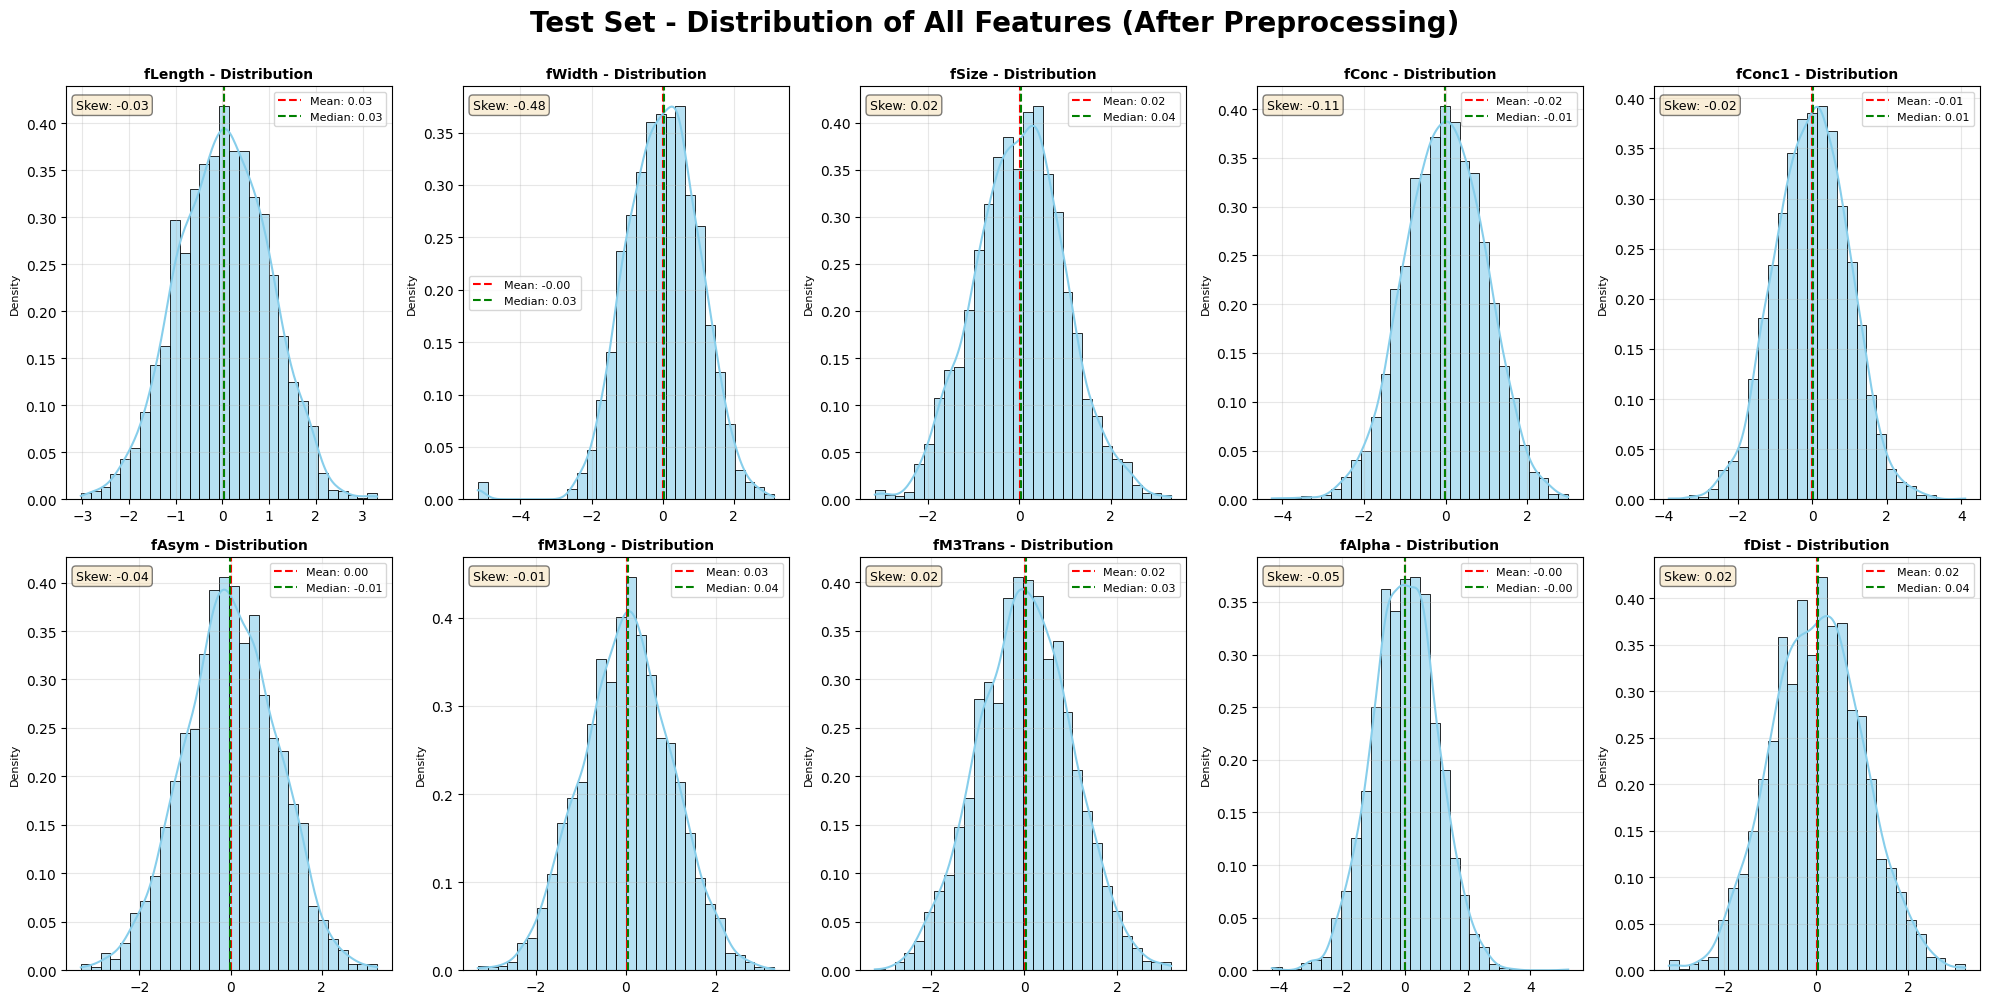

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


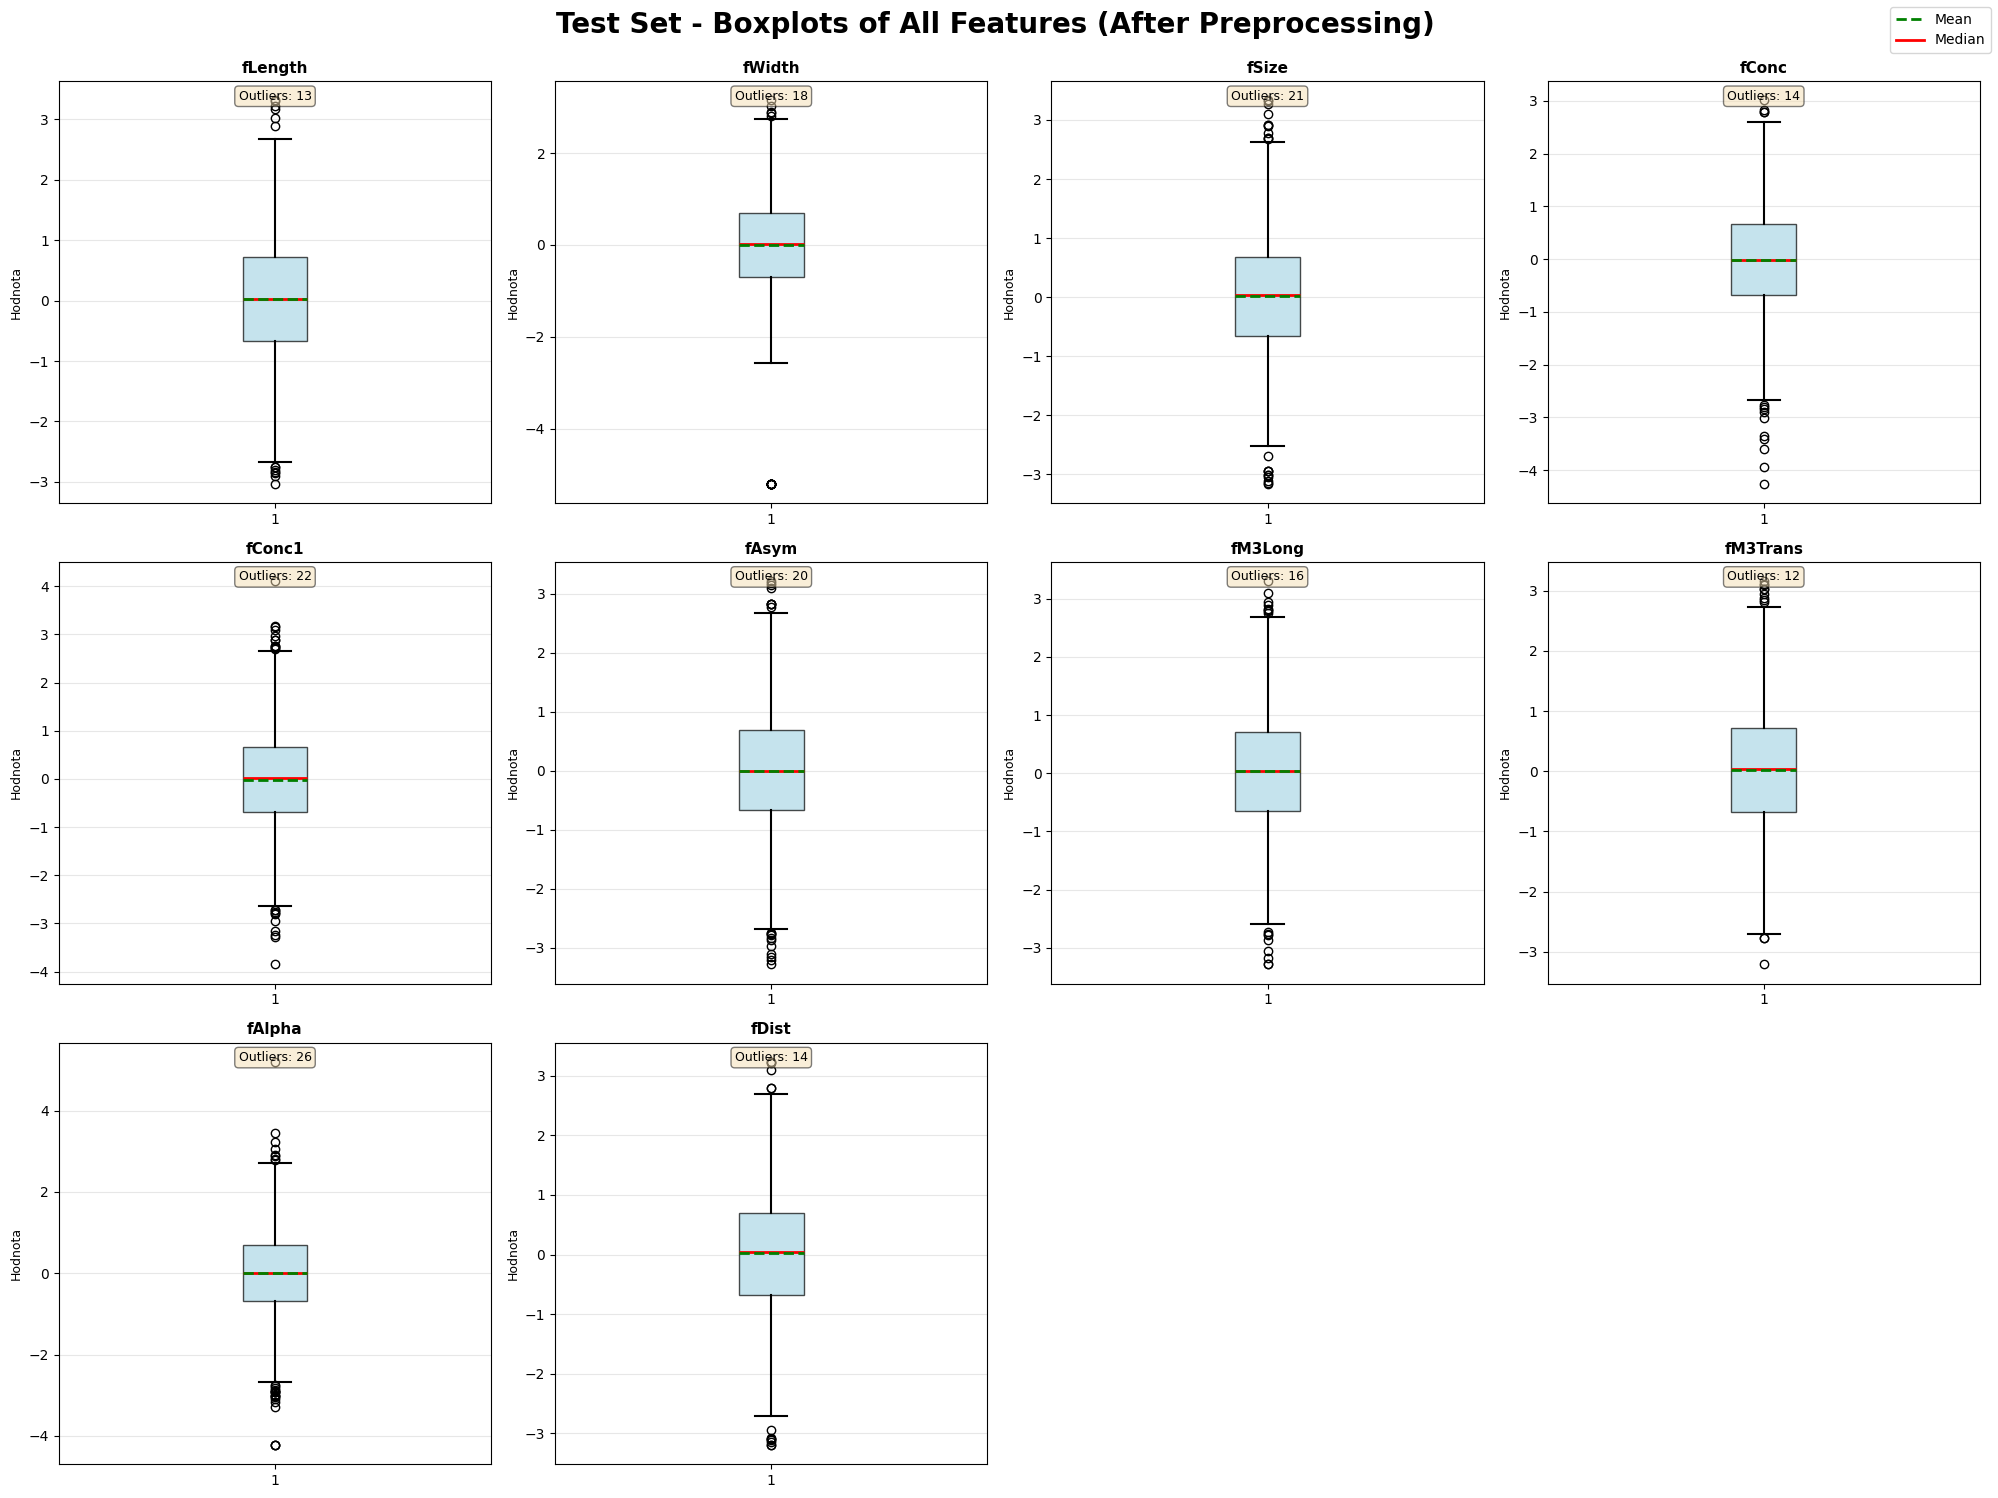

In [18]:
import matplotlib.pyplot as plt
from plotting_tools import visualize_distributions, visualize_outliers_boxplots

# Create DataFrames from processed data for visualization
X_train_df = pd.DataFrame(X_train_processed, columns=X_train.columns)
X_val_df = pd.DataFrame(X_val_processed, columns=X_val.columns)
X_test_df = pd.DataFrame(X_test_processed, columns=X_test.columns)

# Add class labels for split visualization
X_train_df['class'] = y_train.values
X_val_df['class'] = y_val.values
X_test_df['class'] = y_test.values

print("=" * 80)
print("VISUALIZING TRAINING SET (After Preprocessing)")
print("=" * 80)

# Visualize distributions of training set
fig1 = visualize_distributions(
    X_train_df,
    exclude_cols=['class'],
    title='Training Set - Distribution of All Features (After Preprocessing)',
    figsize=(20, 10),
    n_cols=5
)
plt.show()

# Visualize outliers in training set
fig2 = visualize_outliers_boxplots(
    X_train_df,
    exclude_cols=['class'],
    title='Training Set - Boxplots of All Features (After Preprocessing)',
    figsize=(20, 5)
)
plt.show()

print("\n" + "=" * 80)
print("VISUALIZING VALIDATION SET (After Preprocessing)")
print("=" * 80)

# Visualize distributions of validation set
fig3 = visualize_distributions(
    X_val_df,
    exclude_cols=['class'],
    title='Validation Set - Distribution of All Features (After Preprocessing)',
    figsize=(20, 10),
    n_cols=5
)
plt.show()

# Visualize outliers in validation set
fig4 = visualize_outliers_boxplots(
    X_val_df,
    exclude_cols=['class'],
    title='Validation Set - Boxplots of All Features (After Preprocessing)',
    figsize=(20, 5)
)
plt.show()

print("\n" + "=" * 80)
print("VISUALIZING TEST SET (After Preprocessing)")
print("=" * 80)

# Visualize distributions of test set
fig5 = visualize_distributions(
    X_test_df,
    exclude_cols=['class'],
    title='Test Set - Distribution of All Features (After Preprocessing)',
    figsize=(20, 10),
    n_cols=5
)
plt.show()

# Visualize outliers in test set
fig6 = visualize_outliers_boxplots(
    X_test_df,
    exclude_cols=['class'],
    title='Test Set - Boxplots of All Features (After Preprocessing)',
    figsize=(20, 5)
)
plt.show()

## Part 3 - Model Building

In [19]:
# Model Configuration Dictionary
MODEL_CONFIG = {
    # Architecture
    'input_size': X_train.shape[1],
    'hidden_sizes': [256, 128, 128, 64],
    'output_size': 1,
    
    # Activations
    'hidden_activation': 'gelu',  # Options: 'relu', 'leaky_relu', 'tanh', 'sigmoid', 'gelu'
    'output_activation': 'sigmoid',
    
    # Regularization
    'dropout': 0.2,
    'weight_decay': 1e-5,
    
    # Loss and Optimizer
    'loss_function': 'bce',  # Binary Cross Entropy
    'optimizer': 'sgd',  # Options: 'adam', 'adamw', 'sgd', 'rmsprop'
    'learning_rate': 0.01,
    
    # Optional optimizer-specific parameters
    'optimizer_params': {
        # For Adam/AdamW:
        # 'betas': (0.9, 0.999),
        # 'eps': 1e-8,
        # For SGD:
        'momentum': 0.9,
        # For RMSprop:
        # 'alpha': 0.99,
    }
}

# Training Configuration
TRAINING_CONFIG = {
    'epochs': 500,
    'batch_size': 256,
    'patience': 30,
    'verbose': True,
    'best_metric': 'f1',  # Options: 'loss', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'mcc'
    'save_model': True,
    'model_name': 'magic_telescope_model'
}

# Wandb Configuration
WANDB_CONFIG = {
    'project': 'magic-telescope-classification',
    'entity': None,  # Set to your wandb username/team if needed
    'name': 'sgd_run',
    'tags': ['mlp', 'baseline', 'telescope'],
    'notes': 'MLP classifier for Magic Telescope gamma/hadron classification'
}

print("="*80)
print("MODEL CONFIGURATION")
print("="*80)
print(f"Architecture: {MODEL_CONFIG['input_size']} -> {MODEL_CONFIG['hidden_sizes']} -> {MODEL_CONFIG['output_size']}")
print(f"Activation (hidden): {MODEL_CONFIG['hidden_activation']}")
print(f"Activation (output): {MODEL_CONFIG['output_activation']}")
print(f"Dropout: {MODEL_CONFIG['dropout']}")
print(f"Optimizer: {MODEL_CONFIG['optimizer']} (lr={MODEL_CONFIG['learning_rate']}, wd={MODEL_CONFIG['weight_decay']})")
print(f"Loss function: {MODEL_CONFIG['loss_function']}")
print("="*80)
print("\nTRAINING CONFIGURATION")
print("="*80)
print(f"Epochs: {TRAINING_CONFIG['epochs']}")
print(f"Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"Early stopping patience: {TRAINING_CONFIG['patience']}")
print(f"Best metric for selection: {TRAINING_CONFIG['best_metric']}")
print(f"Save model: {TRAINING_CONFIG['save_model']}")
print("="*80)

MODEL CONFIGURATION

MODEL CONFIGURATION
Architecture: 10 -> [256, 128, 128, 64] -> 1
Activation (hidden): gelu
Activation (output): sigmoid
Dropout: 0.2
Optimizer: sgd (lr=0.01, wd=1e-05)
Loss function: bce
Architecture: 10 -> [256, 128, 128, 64] -> 1
Activation (hidden): gelu
Activation (output): sigmoid
Dropout: 0.2
Optimizer: sgd (lr=0.01, wd=1e-05)
Loss function: bce

TRAINING CONFIGURATION
Epochs: 500
Batch size: 256
Early stopping patience: 30
Best metric for selection: f1
Save model: True

TRAINING CONFIGURATION
Epochs: 500
Batch size: 256
Early stopping patience: 30
Best metric for selection: f1
Save model: True


In [20]:
import warnings

class NetworkConfig:
    """
    Configuration class for the Modular MLP network.
    Can be initialized from a dictionary for easy configuration management.
    """
    
    def __init__(self, config_dict=None, **kwargs):
        """
        Initialize from dictionary or keyword arguments.
        
        Args:
            config_dict: Dictionary containing configuration parameters
            **kwargs: Individual configuration parameters
        """
        # Merge dictionary and kwargs
        if config_dict is not None:
            params = {**config_dict, **kwargs}
        else:
            params = kwargs
        
        # Set parameters with defaults
        self.input_size = params.get('input_size')
        self.hidden_sizes = params.get('hidden_sizes', [128, 64])
        self.output_size = params.get('output_size', 1)
        self.hidden_activation = params.get('hidden_activation', 'relu')
        self.output_activation = params.get('output_activation', 'sigmoid')
        self.dropout = params.get('dropout', 0.0)
        self.loss_function = params.get('loss_function', 'bce')
        self.optimizer = params.get('optimizer', 'adam')
        self.learning_rate = params.get('learning_rate', 0.001)
        self.weight_decay = params.get('weight_decay', 1e-5)
        self.optimizer_params = params.get('optimizer_params', {})
        
        # Validate configuration
        self._validate()
    
    def _validate(self):
        """Validate configuration parameters."""
        valid_activations = ['relu', 'leaky_relu', 'tanh', 'sigmoid', 'gelu']
        valid_losses = ['bce', 'bce_with_logits']
        valid_optimizers = ['adam', 'adamw', 'sgd', 'rmsprop']
        
        if self.hidden_activation not in valid_activations:
            raise ValueError(f"hidden_activation must be one of {valid_activations}")
        if self.output_activation not in valid_activations:
            raise ValueError(f"output_activation must be one of {valid_activations}")
        if self.loss_function not in valid_losses:
            raise ValueError(f"loss_function must be one of {valid_losses}")
        if self.optimizer not in valid_optimizers:
            raise ValueError(f"optimizer must be one of {valid_optimizers}")
        if not 0.0 <= self.dropout <= 1.0:
            raise ValueError("dropout must be between 0.0 and 1.0")
        
        # Warnings for common misconfigurations
        if self.loss_function == 'bce' and self.output_activation != 'sigmoid':
            warnings.warn(
                f"BCE loss requires sigmoid output. You have '{self.output_activation}'.",
                UserWarning
            )
    
    def to_dict(self):
        """Convert config to dictionary."""
        return {
            'input_size': self.input_size,
            'hidden_sizes': self.hidden_sizes,
            'output_size': self.output_size,
            'hidden_activation': self.hidden_activation,
            'output_activation': self.output_activation,
            'dropout': self.dropout,
            'loss_function': self.loss_function,
            'optimizer': self.optimizer,
            'learning_rate': self.learning_rate,
            'weight_decay': self.weight_decay,
            'optimizer_params': self.optimizer_params
        }
    
    def __repr__(self):
        return (f"NetworkConfig(\n"
                f"  Architecture: {self.input_size} -> {self.hidden_sizes} -> {self.output_size}\n"
                f"  Activations: hidden={self.hidden_activation}, output={self.output_activation}\n"
                f"  Dropout: {self.dropout}\n"
                f"  Loss: {self.loss_function}\n"
                f"  Optimizer: {self.optimizer} (lr={self.learning_rate}, wd={self.weight_decay})\n"
                f"  Optimizer params: {self.optimizer_params}\n"
                f")")

print("✓ NetworkConfig class loaded successfully!")

✓ NetworkConfig class loaded successfully!



In [21]:
class ModularMLP(nn.Module):
    """
    Modular Multi-Layer Perceptron with configurable architecture.
    
    Features:
    - Dynamic layer construction from config
    - Multiple activation functions
    - Optional dropout after each hidden layer
    - Proper weight initialization
    """
    
    def __init__(self, config: NetworkConfig):
        super(ModularMLP, self).__init__()
        
        self.config = config
        self.network = self._build_network()
        self._initialize_weights()
        
        print(f"\n{'='*60}")
        print(f"Modular MLP Network Created")
        print(f"{'='*60}")
        print(self.config)
        print(f"Total parameters: {self.count_parameters():,}")
        print(f"\nNetwork Architecture:")
        print(self.network)
        print(f"{'='*60}\n")
    
    def _build_network(self):
        """Dynamically build network layers."""
        layer_sizes = [self.config.input_size] + self.config.hidden_sizes + [self.config.output_size]
        modules = []
        
        # Hidden layers
        for i in range(len(layer_sizes) - 2):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            modules.append(self._get_activation(self.config.hidden_activation))
            if self.config.dropout > 0:
                modules.append(nn.Dropout(self.config.dropout))
        
        # Output layer
        modules.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        modules.append(self._get_activation(self.config.output_activation))
        
        return nn.Sequential(*modules)
    
    def _get_activation(self, name: str):
        """Return activation function by name."""
        activations = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'gelu': nn.GELU()
        }
        return activations[name]
    
    def _initialize_weights(self):
        """Initialize network weights."""
        for module in self.network:
            if isinstance(module, nn.Linear):
                if self.config.hidden_activation in ['relu', 'leaky_relu']:
                    nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                else:
                    nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        """Forward pass."""
        return self.network(x)
    
    def count_parameters(self):
        """Count total trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

print("ModularMLP class loaded successfully!")

ModularMLP class loaded successfully!



In [22]:
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_auc_score)
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
import os

class MLPTrainer:
    """
    Training utility for ModularMLP with comprehensive tracking and progress bars.
    """
    
    def __init__(self, model: ModularMLP, config: NetworkConfig, device=None,
                 save_model=False, save_dir='saved_models', model_name=None,
                 best_metric='f1', use_wandb=True):
        """
        Initialize trainer.
        
        Args:
            model: ModularMLP instance
            config: NetworkConfig instance
            device: torch device (defaults to cuda if available)
            save_model: If True, saves best model to disk
            save_dir: Directory to save models
            model_name: Custom model name
            best_metric: Metric for model selection ('loss', 'accuracy', 'f1', etc.)
            use_wandb: Whether to use wandb for experiment tracking
        """
        self.model = model
        self.config = config
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
        # Save settings
        self.save_model = save_model
        self.save_dir = Path(save_dir)
        self.use_wandb = use_wandb
        
        # Best metric configuration
        valid_metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']
        if best_metric not in valid_metrics:
            raise ValueError(f"best_metric must be one of {valid_metrics}")
        
        self.best_metric = best_metric
        self.best_metric_value = float('inf') if best_metric == 'loss' else 0.0
        self.maximize_metric = best_metric != 'loss'
        
        # Generate model name
        if model_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            arch_str = "_".join(map(str, config.hidden_sizes))
            self.model_name = f"mlp_{arch_str}_{config.optimizer}_{timestamp}.pth"
        else:
            self.model_name = model_name if model_name.endswith('.pth') else f"{model_name}.pth"
        
        self.model_path = self.save_dir / self.model_name
        
        if self.save_model:
            self.save_dir.mkdir(parents=True, exist_ok=True)
        
        # Setup loss and optimizer
        self.criterion = self._get_loss_function()
        self.optimizer = self._get_optimizer()
        
        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'train_precision': [], 'val_precision': [],
            'train_recall': [], 'val_recall': [],
            'train_f1': [], 'val_f1': [],
            'train_auc': [], 'val_auc': []
        }
        
        print(f"Trainer initialized on device: {self.device}")
        print(f"Best model selection metric: {self.best_metric}")
        if self.save_model:
            print(f"Models will be saved to: {self.model_path}")
    
    def _get_loss_function(self):
        """Get loss function based on config."""
        if self.config.loss_function == 'bce':
            return nn.BCELoss()
        elif self.config.loss_function == 'bce_with_logits':
            return nn.BCEWithLogitsLoss()
        else:
            raise ValueError(f"Unknown loss function: {self.config.loss_function}")
    
    def _get_optimizer(self):
        """Get optimizer with custom parameters."""
        optimizers_map = {
            'adam': optim.Adam,
            'adamw': optim.AdamW,
            'sgd': optim.SGD,
            'rmsprop': optim.RMSprop
        }
        
        optimizer_class = optimizers_map[self.config.optimizer]
        params = {
            'lr': self.config.learning_rate,
            'weight_decay': self.config.weight_decay
        }
        
        # Add optimizer-specific parameters
        if self.config.optimizer == 'sgd':
            params['momentum'] = self.config.optimizer_params.get('momentum', 0.9)
        elif self.config.optimizer in ['adam', 'adamw']:
            params['betas'] = self.config.optimizer_params.get('betas', (0.9, 0.999))
            params['eps'] = self.config.optimizer_params.get('eps', 1e-8)
        elif self.config.optimizer == 'rmsprop':
            params['alpha'] = self.config.optimizer_params.get('alpha', 0.99)
            params['eps'] = self.config.optimizer_params.get('eps', 1e-8)
            params['momentum'] = self.config.optimizer_params.get('momentum', 0)
        
        return optimizer_class(self.model.parameters(), **params)
    
    def _calculate_metrics(self, labels, preds, probs):
        """Calculate all classification metrics."""
        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, zero_division=0)
        recall = recall_score(labels, preds, zero_division=0)
        f1 = f1_score(labels, preds, zero_division=0)
        
        try:
            auc = roc_auc_score(labels, probs)
        except:
            auc = 0.0
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }
    
    def _is_better_metric(self, current_value, best_value):
        """Check if current metric is better."""
        if self.maximize_metric:
            return current_value > best_value
        else:
            return current_value < best_value

    def train(self, train_loader, val_loader, epochs=100, patience=10, 
              verbose=True, wandb_config=None):
        """
        Train the model with early stopping and progress tracking.
        
        Args:
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data
            epochs: Maximum number of epochs
            patience: Early stopping patience
            verbose: Print progress
            wandb_config: Dictionary with wandb configuration (project, name, etc.)
        """
        
        # Initialize wandb if enabled
        if self.use_wandb:
            self._init_wandb(wandb_config)
        
        best_val_metric = self.best_metric_value
        patience_counter = 0
        best_model_state = None
        best_epoch = 0
        
        print(f"\n{'='*80}")
        print(f"TRAINING CONFIGURATION")
        print(f"{'='*80}")
        print(f"  Epochs: {epochs}")
        print(f"  Batch size: {train_loader.batch_size}")
        print(f"  Steps per epoch: {len(train_loader)}")
        print(f"  Training samples: {len(train_loader.dataset)}")
        print(f"  Validation samples: {len(val_loader.dataset)}")
        print(f"  Best metric: {self.best_metric} ({'maximize' if self.maximize_metric else 'minimize'})")
        print(f"  Save to disk: {'Yes' if self.save_model else 'No'}")
        print(f"  Wandb tracking: {'Yes' if self.use_wandb else 'No'}")
        print(f"{'='*80}\n")
        
        # Training loop with progress bar
        with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
            for epoch in range(epochs):
                # Train and validate
                train_metrics = self._train_epoch(train_loader, verbose=False)
                val_metrics = self._validate_epoch(val_loader, verbose=False)
                
                # Save history
                metric_mapping = {
                    'loss': 'loss',
                    'accuracy': 'acc',
                    'precision': 'precision',
                    'recall': 'recall',
                    'f1': 'f1',
                    'auc': 'auc'
                }
                for metric_name in ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']:
                    history_key = metric_mapping[metric_name]
                    self.history[f'train_{history_key}'].append(train_metrics[metric_name])
                    self.history[f'val_{history_key}'].append(val_metrics[metric_name])
                
                # Log to wandb
                if self.use_wandb:
                    self._log_metrics_to_wandb(epoch, train_metrics, val_metrics)
                
                # Update progress bar
                pbar_postfix = {
                    'train_loss': f"{train_metrics['loss']:.4f}",
                    'val_loss': f"{val_metrics['loss']:.4f}",
                    f'val_{self.best_metric}': f"{val_metrics[self.best_metric]:.4f}",
                }
                pbar.set_postfix(pbar_postfix)
                pbar.update(1)
                
                # Verbose output every 10 epochs
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"\nEpoch [{epoch+1}/{epochs}]")
                    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']:.4f}, "
                          f"F1: {train_metrics['f1']:.4f}, AUC: {train_metrics['auc']:.4f}")
                    print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}, "
                          f"F1: {val_metrics['f1']:.4f}, AUC: {val_metrics['auc']:.4f}")
                
                # Early stopping check
                current_metric_value = val_metrics[self.best_metric]
                
                if self._is_better_metric(current_metric_value, best_val_metric):
                    best_val_metric = current_metric_value
                    patience_counter = 0
                    best_model_state = self.model.state_dict().copy()
                    best_epoch = epoch + 1
                    
                    if self.save_model:
                        self.save_checkpoint(epoch + 1, val_metrics, is_best=True)
                    
                    if verbose:
                        print(f"New best {self.best_metric}: {current_metric_value:.4f}")
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    print(f"\n!!! Early stopping triggered at epoch {epoch+1}")
                    break
        
        # Restore best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print(f"\nRestored best model from epoch {best_epoch} with {self.best_metric}: {best_val_metric:.4f}")
        
        if self.use_wandb:
            wandb.finish()
    
    def _train_epoch(self, train_loader, verbose=True):
        """Train for one epoch with progress bar."""
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        iterator = tqdm(train_loader, desc="Training", leave=False) if verbose else train_loader
        
        for features, labels in iterator:
            features = features.to(self.device)
            labels = labels.to(self.device).float() 
            
            # Forward pass
            outputs = self.model(features)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Track metrics
            total_loss += loss.item()
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.detach().cpu().numpy())
        
        avg_loss = total_loss / len(train_loader)
        metrics = self._calculate_metrics(all_labels, all_preds, all_probs)
        metrics['loss'] = avg_loss
        
        return metrics
    
    def _validate_epoch(self, val_loader, verbose=True):
        """Validate for one epoch with progress bar."""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        iterator = tqdm(val_loader, desc="Validation", leave=False) if verbose else val_loader
        
        with torch.no_grad():
            for features, labels in iterator:
                features = features.to(self.device)
                labels = labels.to(self.device).float()
                
                outputs = self.model(features)
                loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                preds = (outputs >= 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())
        
        avg_loss = total_loss / len(val_loader)
        metrics = self._calculate_metrics(all_labels, all_preds, all_probs)
        metrics['loss'] = avg_loss
        
        return metrics

    def _init_wandb(self, wandb_config):
        """Initialize Weights & Biases tracking with safe login."""
        if wandb_config is None:
            wandb_config = {}
        
        # Try to login with environment variable or prompt user
        try:
            # Check if already logged in
            if wandb.api.api_key is None:
                # Try environment variable first
                api_key = os.environ.get('WANDB_API_KEY')
                if api_key:
                    wandb.login(key=api_key)
                    print("Logged in to wandb using environment variable")
                else:
                    # Prompt user for login
                    print("!!! WANDB_API_KEY not found in environment variables !!!")
                    print("Please login to wandb (you can set WANDB_API_KEY environment variable to avoid this)")
                    wandb.login()
        except Exception as e:
            print(f"!!! Warning: Could not login to wandb !!!: {e}")
            self.use_wandb = False
            return
        
        # Initialize wandb run
        try:
            wandb.init(
                project=wandb_config.get('project', 'ml-project'),
                entity=wandb_config.get('entity', None),
                name=wandb_config.get('name', 'experiment'),
                tags=wandb_config.get('tags', []),
                notes=wandb_config.get('notes', ''),
                config={
                    **self.config.to_dict(),
                    'best_metric': self.best_metric,
                    'device': str(self.device)
                }
            )
            print(f"Wandb initialized: {wandb.run.name}")
        except Exception as e:
            print(f"!!! Warning: Could not initialize wandb: {e}")
            self.use_wandb = False
    
    def _log_metrics_to_wandb(self, epoch, train_metrics, val_metrics):
        """Log metrics to wandb."""
        try:
            log_dict = {'epoch': epoch}
            
            # Log all training metrics
            for metric_name, value in train_metrics.items():
                log_dict[f'train/{metric_name}'] = value
            
            # Log all validation metrics
            for metric_name, value in val_metrics.items():
                log_dict[f'val/{metric_name}'] = value
            
            # Log learning rate
            log_dict['learning_rate'] = self.optimizer.param_groups[0]['lr']
            
            wandb.log(log_dict)
        except Exception as e:
            print(f"!!! Warning: Could not log to wandb !!!: {e}")
    
    def save_checkpoint(self, epoch, val_metrics, is_best=False):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config.to_dict(),
            'history': self.history,
            'val_metrics': val_metrics,
            'best_metric': self.best_metric,
            'best_metric_value': val_metrics.get(self.best_metric),
            'is_best': is_best
        }
        
        torch.save(checkpoint, self.model_path)
        if is_best:
            print(f"Model saved to {self.model_path}")
    
    def evaluate(self, test_loader):
        """Evaluate model on test set with progress bar."""
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for features, labels in tqdm(test_loader, desc="Evaluating on test set"):
                features = features.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(features)
                preds = (outputs >= 0.5).float().squeeze()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())
        
        # Calculate metrics
        metrics = self._calculate_metrics(all_labels, all_preds, all_probs)
        conf_matrix = confusion_matrix(all_labels, all_preds)
        class_report = classification_report(all_labels, all_preds, 
                                            target_names=['Class 0 (h)', 'Class 1 (g)'])
        
        # Print header and classification report
        print(f"\n{'='*80}")
        print(f"TEST SET EVALUATION")
        print(f"{'='*80}")
        print(f"\nClassification Report:")
        print(class_report)
        print(f"{'='*80}\n")
        
        # Create visualizations
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        # Plot 1: Confusion Matrix as Heatmap
        ax1 = axes[0]
        im = ax1.imshow(conf_matrix, cmap='Blues', aspect='auto')
        
        # Add text annotations to confusion matrix
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                text = ax1.text(j, i, conf_matrix[i, j],
                               ha="center", va="center", color="black", fontsize=14, fontweight='bold')
        
        ax1.set_xticks([0, 1])
        ax1.set_yticks([0, 1])
        ax1.set_xticklabels(['Predicted h (0)', 'Predicted g (1)'], fontsize=11)
        ax1.set_yticklabels(['Actual h (0)', 'Actual g (1)'], fontsize=11)
        ax1.set_title('Confusion Matrix', fontsize=13, fontweight='bold')
        ax1.set_ylabel('True Label', fontsize=11)
        ax1.set_xlabel('Predicted Label', fontsize=11)
        plt.colorbar(im, ax=ax1, label='Count')
        
        # Plot 2: Metrics Bar Plot with Annotations
        ax2 = axes[1]
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
        metric_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], 
                        metrics['f1'], metrics['auc']]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        
        bars = ax2.bar(metric_names, metric_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value annotations on top of bars
        for bar, value in zip(bars, metric_values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.4f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax2.set_ylabel('Score', fontsize=11)
        ax2.set_title('Test Metrics', fontsize=13, fontweight='bold')
        ax2.set_ylim(0, 1.1)
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        ax2.set_xticks(range(len(metric_names)))
        ax2.set_xticklabels(metric_names, rotation=15, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # Log to wandb if enabled
        if self.use_wandb:
            try:
                wandb.log({
                    'test/accuracy': metrics['accuracy'],
                    'test/precision': metrics['precision'],
                    'test/recall': metrics['recall'],
                    'test/f1': metrics['f1'],
                    'test/auc': metrics['auc']
                })
            except:
                pass
        
        return metrics, conf_matrix, all_preds, all_probs
    
    def plot_history(self):
        """Plot training history."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        metrics = [
            ('Loss', 'train_loss', 'val_loss'),
            ('Accuracy', 'train_acc', 'val_acc'),
            ('Precision', 'train_precision', 'val_precision'),
            ('Recall', 'train_recall', 'val_recall'),
            ('F1-Score', 'train_f1', 'val_f1'),
            ('ROC-AUC', 'train_auc', 'val_auc')
        ]
        
        for idx, (title, train_key, val_key) in enumerate(metrics):
            row = idx // 3
            col = idx % 3
            ax = axes[row, col]
            
            ax.plot(self.history[train_key], label=f'Train {title}', 
                   color='blue', alpha=0.7, linewidth=2)
            ax.plot(self.history[val_key], label=f'Val {title}', 
                   color='orange', alpha=0.7, linewidth=2)
            ax.set_xlabel('Epoch', fontsize=11)
            ax.set_ylabel(title, fontsize=11)
            ax.set_title(f'{title} Over Time', fontsize=12, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


### Initialize Model and Trainer

In [23]:
# Create network configuration from dictionary
config = NetworkConfig(config_dict=MODEL_CONFIG)

# Create model
model = ModularMLP(config)

# Create trainer
trainer = MLPTrainer(
    model=model,
    config=config,
    save_model=TRAINING_CONFIG['save_model'],
    model_name=TRAINING_CONFIG['model_name'],
    best_metric=TRAINING_CONFIG['best_metric'],
    use_wandb=True  # Set to False to disable wandb tracking
)

print("\nModel and trainer initialized successfully!")
print(f"Model has {model.count_parameters():,} trainable parameters")


Modular MLP Network Created
NetworkConfig(
  Architecture: 10 -> [256, 128, 128, 64] -> 1
  Activations: hidden=gelu, output=sigmoid
  Dropout: 0.2
  Loss: bce
  Optimizer: sgd (lr=0.01, wd=1e-05)
  Optimizer params: {'momentum': 0.9}
)
Total parameters: 60,545

Network Architecture:
Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): GELU(approximate='none')
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): GELU(approximate='none')
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): GELU(approximate='none')
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): GELU(approximate='none')
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=64, out_features=1, bias=True)
  (13): Sigmoid()
)

Trainer initialized on device: cpu
Modular MLP Network Created
NetworkConfig(
  Architecture: 10 -> [256, 1

### Train the Model

In [24]:
# Train the model
trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=TRAINING_CONFIG['epochs'],
    patience=TRAINING_CONFIG['patience'],
    verbose=TRAINING_CONFIG['verbose'],
    wandb_config=WANDB_CONFIG
)

print("\nTraining completed!")

Wandb initialized: sgd_run

TRAINING CONFIGURATION
  Epochs: 500

TRAINING CONFIGURATION
  Epochs: 500

  Batch size: 64
  Steps per epoch: 207
  Training samples: 13233
  Validation samples: 2836
  Batch size: 64
  Steps per epoch: 207
  Training samples: 13233
  Validation samples: 2836
  Best metric: f1 (maximize)
  Save to disk: Yes
  Wandb tracking: Yes

  Best metric: f1 (maximize)
  Save to disk: Yes
  Wandb tracking: Yes



Wandb initialized: sgd_run

TRAINING CONFIGURATION
  Epochs: 500

TRAINING CONFIGURATION
  Epochs: 500

  Batch size: 64
  Steps per epoch: 207
  Training samples: 13233
  Validation samples: 2836
  Batch size: 64
  Steps per epoch: 207
  Training samples: 13233
  Validation samples: 2836
  Best metric: f1 (maximize)
  Save to disk: Yes
  Wandb tracking: Yes

  Best metric: f1 (maximize)
  Save to disk: Yes
  Wandb tracking: Yes



Training Progress:   0%|          | 0/500 [00:00<?, ?epoch/s]

Wandb initialized: sgd_run

TRAINING CONFIGURATION
  Epochs: 500

TRAINING CONFIGURATION
  Epochs: 500

  Batch size: 64
  Steps per epoch: 207
  Training samples: 13233
  Validation samples: 2836
  Batch size: 64
  Steps per epoch: 207
  Training samples: 13233
  Validation samples: 2836
  Best metric: f1 (maximize)
  Save to disk: Yes
  Wandb tracking: Yes

  Best metric: f1 (maximize)
  Save to disk: Yes
  Wandb tracking: Yes



Training Progress:   0%|          | 0/500 [00:00<?, ?epoch/s]

Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8629

New best f1: 0.8629
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8731
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8731
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8810
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8810
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8893
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8893
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8971
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8971
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8986
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.8986
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.9005
Model saved to saved_models\magic_telescope_model.pth
New best f1: 0.9005

Epoch [10/500]
 


✓ Training completed!


### Visualize Training History

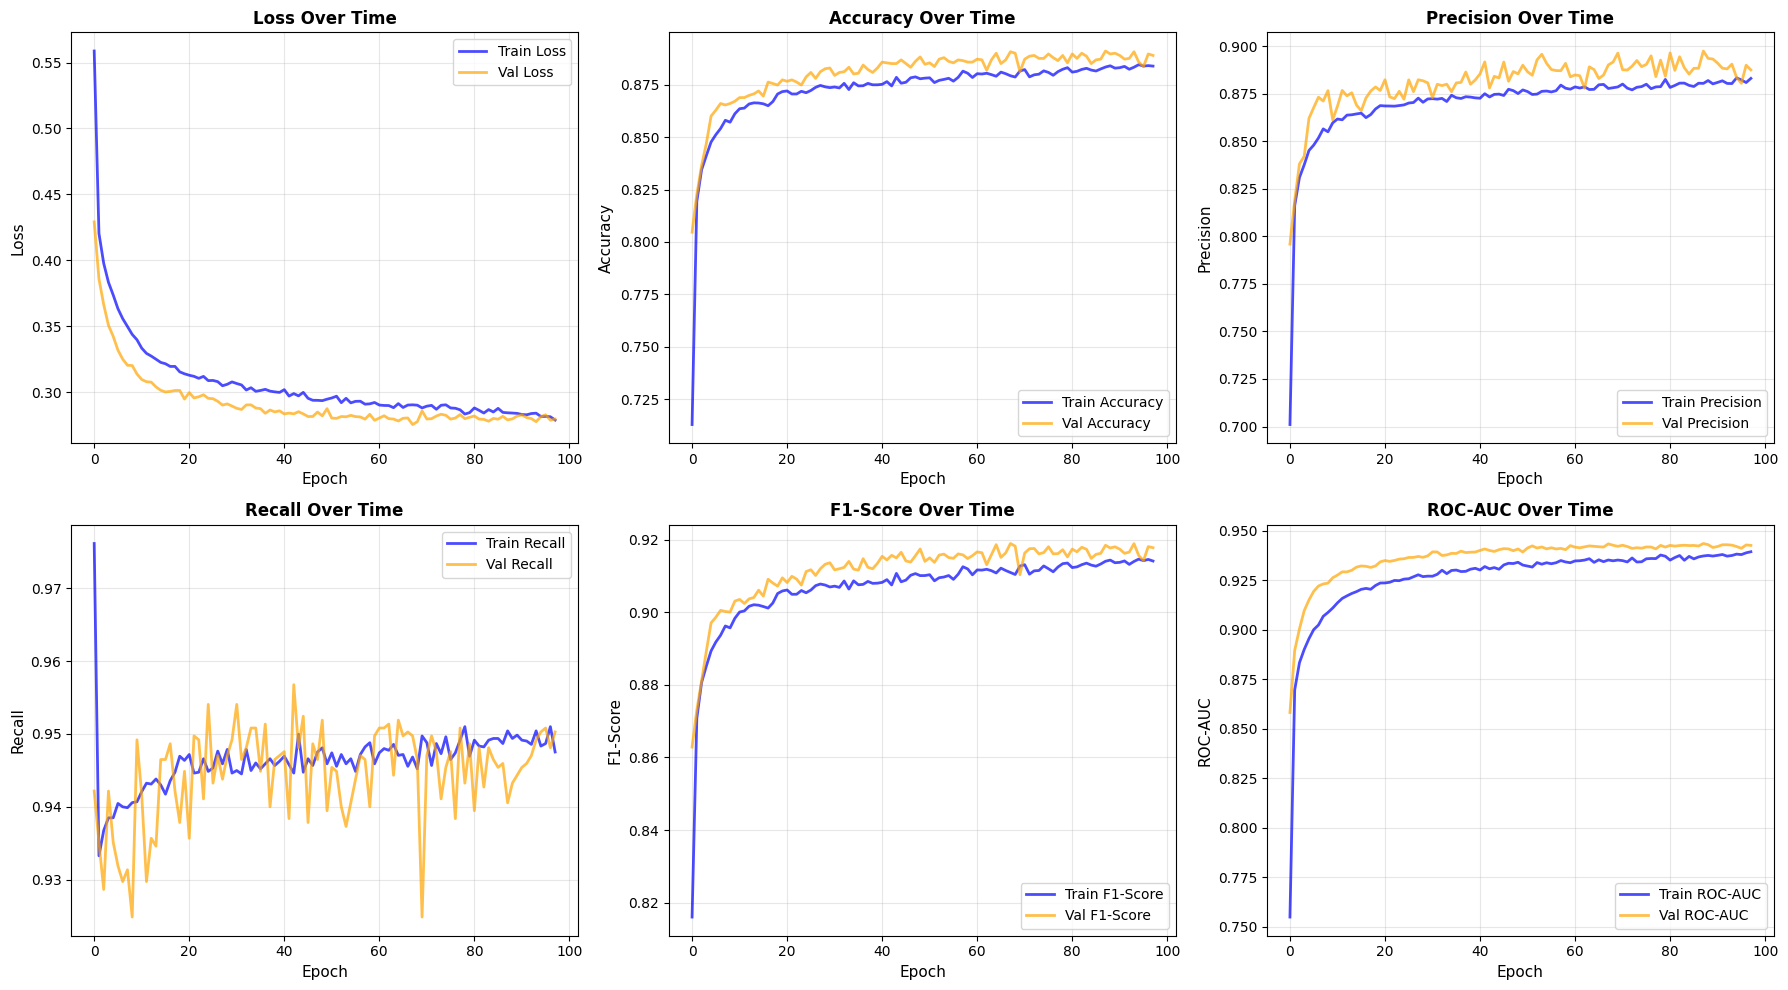

In [25]:
# Plot training history
trainer.plot_history()

### Evaluate on Test Set

Evaluating on test set:   0%|          | 0/45 [00:00<?, ?it/s]


TEST SET EVALUATION

Classification Report:
              precision    recall  f1-score   support

 Class 0 (h)       0.90      0.76      0.82       986
 Class 1 (g)       0.88      0.96      0.92      1850

    accuracy                           0.89      2836
   macro avg       0.89      0.86      0.87      2836
weighted avg       0.89      0.89      0.88      2836




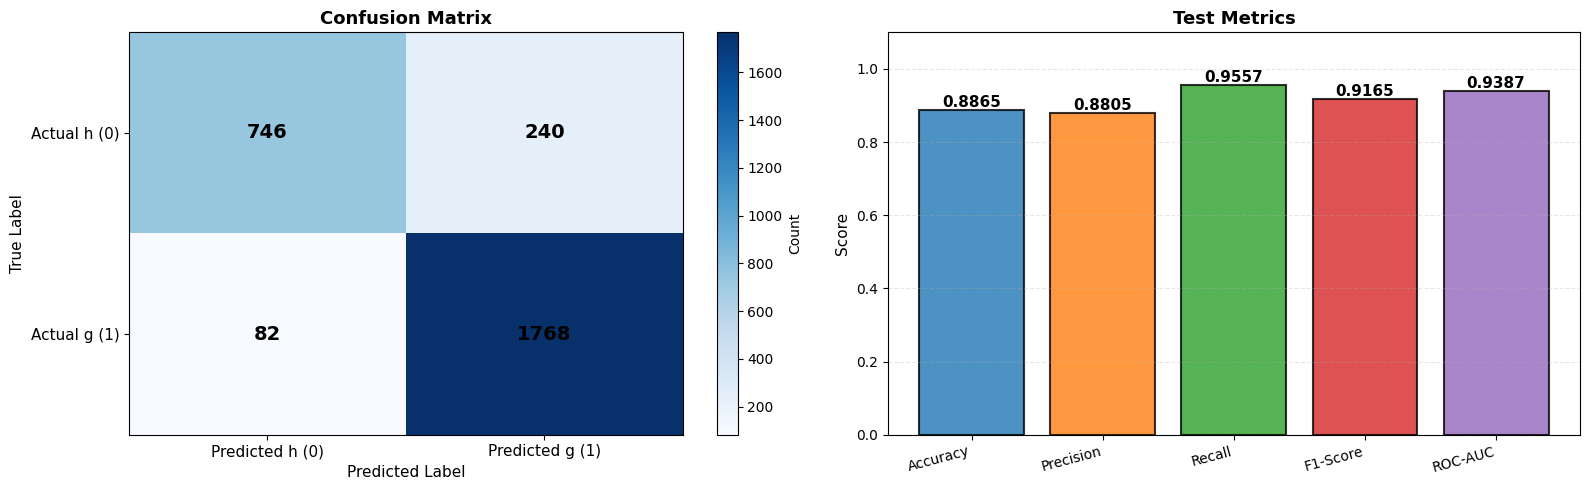

In [26]:
# Evaluate on test set
test_metrics, conf_matrix, test_preds, test_probs = trainer.evaluate(test_loader)